# AI 를 이용한 컴퓨터 부하 예측 


## Model
- Single-variate forecasting
- Multivariate forecasting

## Function
- Price
    - LNG 단가는 월 초에 설정
        - LNG (업체마다 단가가 조금 달라서, 이건 직접 입력)/ BC 단가는 주어지므로 constant 입력 (BC에 대해서만 싸이버페트로넷---> API로 따오기 (인터페이스개발 업체에 문의)
    - CO2 가격 (API로 따올 수 있는지 문의, https://ets.krx.co.kr/contents/ETS/03/03010000/ETS03010000.jsp)
    - BC price는 일주일~15일마다 변경
    - A사: 사용한 스팀량에 따라 가격 수정 (실시간) 
    - B/C 사: 평균 enthalpy에 따라 가격 수정 (실시간)
- Optimization 
    - (minimize) 스팀사용비용 + CO2 사용 비용 
    - (subject to) (1) 수요보다 같거나 크게 스팀을 사온다. (2) 공급중단 스케줄에 해당하면 스팀 공급 가능량은 0. 

## Input
- DB information 
    - 


## Output
- t 시간 후 부하




# Package Install

In [1]:
!pip install sktime
!pip install mysql-connector-python




# Package loading

In [2]:
import os
import calendar
import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import mysql.connector

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import logging
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True #  turn 'cmdstanpy' logs off

from sktime.forecasting.croston import Croston
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import TrendForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.structural import UnobservedComponents
from sktime.forecasting.dummy import ForecastKnownValues
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.forecasting.compose import EnsembleForecaster



#  MySQL conneting

In [3]:
my_conn = mysql.connector.connect(
      host="localhost",
      user="userid",
      passwd="******",
      database="my_tutorial"
    )
####### end of connection ####
my_data = pd.read_sql("SELECT * FROM student WHERE class='four'",my_conn)
print(my_data)


# Forcasting

In [5]:


def discount_mae_fun(y_true, y_pred, discount_factor):
    validation = []
    y_diff = y_true-y_pred
    for t, val in enumerate(y_diff):
        penalty_val= abs(val)*discount_factor**t
        # print(idx, val,t, penalty_val)
        validation.append(penalty_val)
    return round(np.mean(validation), 2) 
def performance_fun(y_true, y_pred):
    y_diff = y_true-y_pred
    return round(abs(y_diff[-1])/y_true[-1]*100, 2)




month = 1

x = [3, 1.1, 3 ] # past_ob_n, discount_factor, n_e
def A_forecasting(x, month_list=[1, 3], fig=False):
    
    past_ob_n = x[0]
    discount_factor = x[1]
    n_e = x[2]
    final_result =[]
    for month in month_list:

        
        init_date = datetime.date(2022, month, 1)
        month_day = calendar.monthrange(2002, month)[1]
        end_date = init_date + datetime.timedelta(days = month_day-1)
        df_ts_1m = df_ts.loc[init_date:end_date, ['A사 유량']].copy()
        df_ts_1m['cum'] = 0
        cum = 0
        for idx, val in df_ts_1m.iterrows():
            cum += val['A사 유량']
            df_ts_1m.loc[idx,'cum'] = cum
        df_ts_1m = df_ts_1m.resample('1D').first()



        for itter in range(2, month_day-1): #month_day ,
            model_performances = dict()
            model_nm2model = dict()
            if past_ob_n >= itter:
                past_ob = itter-2
            else:
                past_ob = past_ob_n-1
            

            past_ob_td = datetime.timedelta(days = past_ob)
            idx_td = datetime.timedelta(days = itter)
            oneday_td = datetime.timedelta(days=1)

            t_date = init_date+idx_td
            ob_date = t_date-past_ob_td

            test_fh = -((ob_date-t_date).days)
            fh = range(1,test_fh+2)

            if fig == True:
                ax = df_ts_1m['cum'].loc[init_date:end_date].plot(label='Steam flow for company A')#'2022-01-26 00:00:00'

            y = df_ts_1m['cum'].loc[init_date:ob_date-oneday_td]
            y_true = df_ts_1m['cum'].loc[ob_date:t_date]
            # Prophet requires to have data with a pandas.DatetimeIndex
            model_nm = 'Prophet'
            forecaster = Prophet(  
                seasonality_mode='multiplicative',
                add_country_holidays={'country_name': 'Korea'},
                )
            forecaster.fit(y)  
            y_pred = forecaster.predict(fh=fh)  
            valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
            y_pred_int = forecaster.predict_interval(coverage=0.9)
            label = f'{model_nm}:{valid_val}'
            model_performances[model_nm] = valid_val
            model_nm2model[model_nm] = forecaster
            if fig == True:
                y_pred.plot(ax=ax, label=label)


            # model_nm = 'Auto ARIMA'
            # forecaster = AutoARIMA(d=0, max_p=2, max_q=2, suppress_warnings=True)  
            # forecaster.fit(y)  
            # y_pred = forecaster.predict(fh=fh)  
            # valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
            # label = f'{model_nm}:{valid_val}'
            # model_performances[model_nm] = valid_val
            # model_nm2model[model_nm] = forecaster
            # if fig == True:
            #     y_pred.plot(ax=ax, label=label)


            # model_nm = 'Croston'
            # forecaster = Croston(smoothing=0.1)
            # forecaster.fit(y)
            # y_pred = forecaster.predict(fh=fh)  
            # valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
            # label = f'{model_nm}:{valid_val}'
            # model_performances[model_nm] = valid_val
            # model_nm2model[model_nm] = forecaster
            # if fig == True:
            #     y_pred.plot(ax=ax, label=label)

            model_nm = 'Exponential smoothing (ETS)'
            forecaster = ExponentialSmoothing(
                trend='add', #seasonal='multiplicative', #sp=12
            )  
            forecaster.fit(y)  
            y_pred = forecaster.predict(fh=fh)  
            valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
            label = f'{model_nm}:{valid_val}'
            model_performances[model_nm] = valid_val
            model_nm2model[model_nm] = forecaster
            if fig == True:
                y_pred.plot(ax=ax, label=label)

            model_nm = 'ARIMA'
            forecaster = ARIMA()
            forecaster.fit(y)  
            y_pred = forecaster.predict(fh=fh)  
            valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
            label = f'{model_nm}:{valid_val}'
            model_performances[model_nm] = valid_val
            model_nm2model[model_nm] = forecaster
            if fig == True:
                y_pred.plot(ax=ax, label=label)


            model_nm = 'PolynomialTrendForecaster'
            forecaster = PolynomialTrendForecaster()  
            forecaster.fit(y)  
            y_pred = forecaster.predict(fh=fh)  
            valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
            label = f'{model_nm}:{valid_val}'
            model_performances[model_nm] = valid_val
            model_nm2model[model_nm] = forecaster
            if fig == True:
                y_pred.plot(ax=ax, label=label)

            model_nm = 'TrendForecaster'
            forecaster = TrendForecaster()  
            forecaster.fit(y)  
            y_pred = forecaster.predict(fh=fh)  
            valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
            label = f'{model_nm}:{valid_val}'
            model_performances[model_nm] = valid_val
            model_nm2model[model_nm] = forecaster
            if fig == True:
                y_pred.plot(ax=ax, label=label)


            model_nm = 'ThetaForecaster'
            forecaster = ThetaForecaster()  
            forecaster.fit(y)  
            y_pred = forecaster.predict(fh=fh)  
            valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
            label = f'{model_nm}:{valid_val}'
            model_performances[model_nm] = valid_val
            model_nm2model[model_nm] = forecaster
            if fig == True:
                y_pred.plot(ax=ax, label=label)

            model_nm = 'Naive'
            forecaster = NaiveForecaster(strategy="drift")
            forecaster.fit(y)  
            y_pred = forecaster.predict(fh=fh)  
            y_pred_int = forecaster.predict_interval(coverage=0.9)
            valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
            label = f'{model_nm}:{valid_val}'
            model_performances[model_nm] = valid_val
            model_nm2model[model_nm] = forecaster
            if fig == True:
                y_pred.plot(ax=ax, label=label)

            # model_nm = 'local linear trend'
            # forecaster = UnobservedComponents()  
            # forecaster.fit(y)  
            # y_pred = forecaster.predict(fh=fh)  
            # valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
            # label = f'{model_nm}:{valid_val}'
            # model_performances[model_nm] = valid_val
            # model_nm2model[model_nm] = forecaster
            # if fig == True:
            #     y_pred.plot(ax=ax, label=label)

            # if fig == True:
            #     y_pred.plot(ax=ax, label=label)
            #     ax.legend()
            #     plt.show()


            selected_model_nm = sorted(model_performances, key=model_performances.get, reverse=False)[:n_e]
            inverse_mae_sum = []
            for i in selected_model_nm:
                inverse_mae_sum.append(model_performances[i])
            weights = []
            for i in selected_model_nm:
                weight = model_performances[i]/sum(inverse_mae_sum)
                weights.append(weight)
            weights =list(reversed(weights))



            y = df_ts_1m['cum'].loc[init_date:t_date-oneday_td]
            y_true = df_ts_1m['cum'].loc[t_date:end_date]

            test_fh = ((end_date-t_date).days)
            fh = range(1,test_fh+2)

            # print(f'start_date: {init_date} | end_date: {t_date-oneday_td} | fh: {t_date+oneday_td}~{end_date} | fh:{fh} | until: {init_date}~{end_date}')


            forecasters = []
            for model_nm in selected_model_nm:
                forecasters.append((model_nm, model_nm2model[model_nm]))
            forecaster = EnsembleForecaster(forecasters=forecasters, weights=weights)#, weights=[4, 10]
            forecaster.fit(y=y)
            y_pred = forecaster.predict(fh=fh)  
            # valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
            valid_val = performance_fun(y_true, y_pred)
            if fig == True:
                print(selected_model_nm)
                ax = df_ts_1m['cum'].loc[init_date:end_date].plot(label='Steam flow for company A')#'2022-01-26 00:00:00'
                label = f'ensemble:{valid_val}'
                y_pred.plot(ax=ax, label=label)
                ax.legend()
                plt.show()
            final_result.append(valid_val)
            print(f'\t⏳ progress{itter}|{x}|valid: {valid_val}| start_date: {init_date} | end_date: {ob_date-oneday_td} | valid: {ob_date}~{t_date} |fh: {test_fh} | until: {init_date}~{end_date}', end='\r')

        mean_mae = np.mean(final_result)
    return mean_mae, final_result


# Code

In [10]:

#def performance_compare(x, month_list=[1, 3], fig=False):

x = [2, 1.2, 3]
month_list = [1]
fig = False
past_ob_n = x[0]
discount_factor = x[1]
n_e = x[2]
final_result_value =[]
final_result_nm2model =[]
for month in month_list:

    
    init_date = datetime.date(2022, month, 1)
    month_day = calendar.monthrange(2002, month)[1]
    end_date = init_date + datetime.timedelta(days = month_day-1)
    df_ts_1m = df_ts.loc[init_date:end_date, ['A사 유량']].copy()
    df_ts_1m['cum'] = 0
    cum = 0
    for idx, val in df_ts_1m.iterrows():
        cum += val['A사 유량']
        df_ts_1m.loc[idx,'cum'] = cum
    df_ts_1m = df_ts_1m.resample('1D').first()



    for itter in range(2, month_day-1): #month_day ,



        model_performances = dict()
        model_nm2model = dict()
        if past_ob_n >= itter:
            past_ob = itter-2
        else:
            past_ob = past_ob_n-1
        

        past_ob_td = datetime.timedelta(days = past_ob)
        idx_td = datetime.timedelta(days = itter)
        oneday_td = datetime.timedelta(days=1)

        t_date = init_date+idx_td
        ob_date = t_date-past_ob_td

        y = df_ts_1m['cum'].loc[init_date:t_date-oneday_td]
        y_true = df_ts_1m['cum'].loc[t_date:end_date]

        test_fh = ((end_date-t_date).days)
        fh = range(1,test_fh+2)




        if fig == True:
            ax = df_ts_1m['cum'].loc[init_date:end_date].plot(label='Steam flow for company A')#'2022-01-26 00:00:00'

        # Prophet requires to have data with a pandas.DatetimeIndex
        model_nm = 'Prophet'
        forecaster = Prophet(  
            seasonality_mode='multiplicative',
            add_country_holidays={'country_name': 'Korea'},
            )
        forecaster.fit(y)  
        y_pred = forecaster.predict(fh=fh)  
        valid_val = performance_fun(y_true, y_pred)
        y_pred_int = forecaster.predict_interval(coverage=0.9)
        label = f'{model_nm}:{valid_val}'
        model_performances[model_nm] = valid_val
        model_nm2model[model_nm] = forecaster
        if fig == True:
            y_pred.plot(ax=ax, label=label)

        # model_nm = 'Auto ARIMA'
        # forecaster = AutoARIMA(d=0, max_p=2, max_q=2, suppress_warnings=True)  
        # forecaster.fit(y)  
        # y_pred = forecaster.predict(fh=fh)  
        # valid_val = performance_fun(y_true, y_pred)
        # label = f'{model_nm}:{valid_val}'
        # model_performances[model_nm] = valid_val
        # model_nm2model[model_nm] = forecaster
        # if fig == True:
        #     y_pred.plot(ax=ax, label=label)


        model_nm = 'Croston'
        forecaster = Croston(smoothing=0.1)
        forecaster.fit(y)
        y_pred = forecaster.predict(fh=fh)  
        valid_val = performance_fun(y_true, y_pred)
        label = f'{model_nm}:{valid_val}'
        model_performances[model_nm] = valid_val
        model_nm2model[model_nm] = forecaster
        if fig == True:
            y_pred.plot(ax=ax, label=label)

        model_nm = 'Exponential smoothing (ETS)'
        forecaster = ExponentialSmoothing(
            trend='add', #seasonal='multiplicative', #sp=12
        )  
        forecaster.fit(y)  
        y_pred = forecaster.predict(fh=fh)  
        valid_val = performance_fun(y_true, y_pred)
        label = f'{model_nm}:{valid_val}'
        model_performances[model_nm] = valid_val
        model_nm2model[model_nm] = forecaster
        if fig == True:
            y_pred.plot(ax=ax, label=label)

        model_nm = 'ARIMA'
        forecaster = ARIMA()
        forecaster.fit(y)  
        y_pred = forecaster.predict(fh=fh)  
        valid_val = performance_fun(y_true, y_pred)
        label = f'{model_nm}:{valid_val}'
        model_performances[model_nm] = valid_val
        model_nm2model[model_nm] = forecaster
        if fig == True:
            y_pred.plot(ax=ax, label=label)


        model_nm = 'PolynomialTrendForecaster'
        forecaster = PolynomialTrendForecaster()  
        forecaster.fit(y)  
        y_pred = forecaster.predict(fh=fh)  
        valid_val = performance_fun(y_true, y_pred)
        label = f'{model_nm}:{valid_val}'
        model_performances[model_nm] = valid_val
        model_nm2model[model_nm] = forecaster
        if fig == True:
            y_pred.plot(ax=ax, label=label)

        model_nm = 'TrendForecaster'
        forecaster = TrendForecaster()  
        forecaster.fit(y)  
        y_pred = forecaster.predict(fh=fh)  
        valid_val = performance_fun(y_true, y_pred)
        label = f'{model_nm}:{valid_val}'
        model_performances[model_nm] = valid_val
        model_nm2model[model_nm] = forecaster
        if fig == True:
            y_pred.plot(ax=ax, label=label)


        model_nm = 'ThetaForecaster'
        forecaster = ThetaForecaster()  
        forecaster.fit(y)  
        y_pred = forecaster.predict(fh=fh)  
        valid_val = performance_fun(y_true, y_pred)
        label = f'{model_nm}:{valid_val}'
        model_performances[model_nm] = valid_val
        model_nm2model[model_nm] = forecaster
        if fig == True:
            y_pred.plot(ax=ax, label=label)

        model_nm = 'Naive'
        forecaster = NaiveForecaster(strategy="drift")
        forecaster.fit(y)  
        y_pred = forecaster.predict(fh=fh)  
        y_pred_int = forecaster.predict_interval(coverage=0.9)
        valid_val = performance_fun(y_true, y_pred)
        label = f'{model_nm}:{valid_val}'
        model_performances[model_nm] = valid_val
        model_nm2model[model_nm] = forecaster
        if fig == True:
            y_pred.plot(ax=ax, label=label)

        # model_nm = 'local linear trend'
        # forecaster = UnobservedComponents()  
        # forecaster.fit(y)  
        # y_pred = forecaster.predict(fh=fh)  
        # valid_val = performance_fun(y_true, y_pred)
        # label = f'{model_nm}:{valid_val}'
        # model_performances[model_nm] = valid_val
        # model_nm2model[model_nm] = forecaster
        # if fig == True:
        #     y_pred.plot(ax=ax, label=label)

        # if fig == True:
        #     y_pred.plot(ax=ax, label=label)
        #     ax.legend()
        #     plt.show()
        
        final_result_value.append(model_performances)
        final_result_nm2model.append(model_nm2model)



    


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarnin

In [11]:
compare_table = dict()
model_nm = list(final_result_value[0].keys())
for nm in model_nm:
    compare_table[nm] = []

for i in range(len(final_result_value)):
    dummy_dict = final_result_value[i]
    for nm in list(dummy_dict.keys()):
        compare_table[nm].append(dummy_dict[nm])


compare_table = pd.DataFrame.from_dict(compare_table, orient='index').T
compare_table


Prophet  Croston  Exponential smoothing (ETS)  ARIMA  \
0     21.20    99.73                        34.59  99.97   
1     13.98    99.21                        19.80  97.41   
2      0.11    98.35                         4.01  95.51   
3     13.72    97.10                         4.75  93.18   
4     24.15    95.46                        50.03  90.18   
5     26.08    93.57                        18.73  86.68   
6     27.41    91.43                        29.73  82.87   
7     31.73    89.07                        29.21  77.36   
8     28.20    86.57                        23.63  72.44   
9     25.85    83.94                        23.15  80.56   
10    21.59    81.44                        12.52  71.87   
11     2.00    78.94                         4.44  75.37   
12     3.06    76.29                         9.69  57.49   
13    10.76    73.50                        11.13  53.31   
14     6.36    70.59                        11.85  52.52   
15     2.86    67.70                         8.82  52.76   
16     0.06    64.98                         1.42  45.78   
17     0.48    62.33                         2.71  43.65   
18     1.47    59.52                        12.28  37.38   
19     1.86    56.55                         4.11  32.08   
20     2.30    53.55                         3.77  28.74   
21     1.88    50.47                         4.73  24.24   
22     1.89    47.43                         3.32  21.23   
23     1.71    44.59                         1.31  23.90   
24     1.57    41.93                         6.01  18.85   
25     0.34    39.43                        12.13  17.53   
26     2.15    36.76                         4.79  13.10   
27     2.49    33.91                         0.46   8.81   

    PolynomialTrendForecaster  TrendForecaster  ThetaForecaster  Naive  
0                       22.06            22.06            58.43  22.06  
1                       17.92            17.92            54.83  17.88  
2                        7.75             7.75            47.50   6.78  
3                        4.35             4.35            38.59   6.10  
4                       14.84            14.84            30.37  16.24  
5                       18.86            18.86            26.54  16.74  
6                       21.62            21.62            22.89  19.26  
7                       23.42            23.42            19.80  20.83  
8                       23.63            23.63            18.09  19.77  
9                       23.22            23.22            16.58  19.06  
10                      20.11            20.11            18.47  11.93  
11                      16.89            16.89            19.17   8.81  
12                      15.01            15.01            17.72   9.86  
13                      13.91            13.91            15.98  10.64  
14                      13.27            13.27            14.14  11.17  
15                      12.27            12.27            13.66   9.20  
16                      10.54            10.54            14.70   5.12  
17                       8.66             8.66            15.07   2.55  
18                       7.52             7.52            12.94   3.83  
19                       6.96             6.96            10.45   5.25  
20                       6.46             6.46             9.05   4.89  
21                       6.17             6.17             7.06   5.31  
22                       5.77             5.77             6.12   4.32  
23                       4.96             4.96             6.97   1.23  
24                       3.86             3.86             7.90   1.69  
25                       2.62             2.62             8.61   4.16  
26                       1.79             1.79             6.09   2.96  
27                       1.28             1.28             3.40   1.73

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Prophet', 'PolynomialTrendForecaster', 'TrendForecaster']


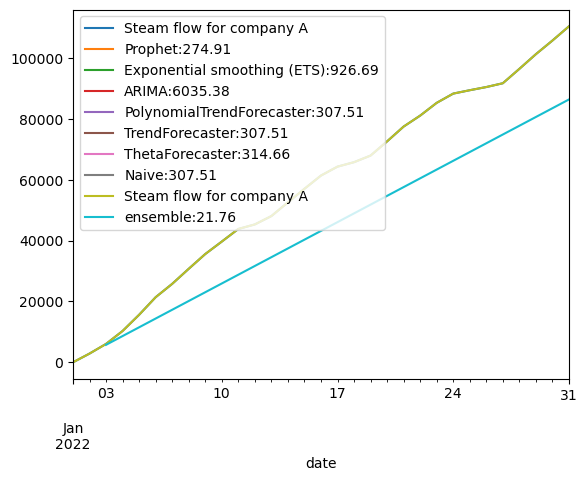

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Prophet', 'PolynomialTrendForecaster', 'TrendForecaster']


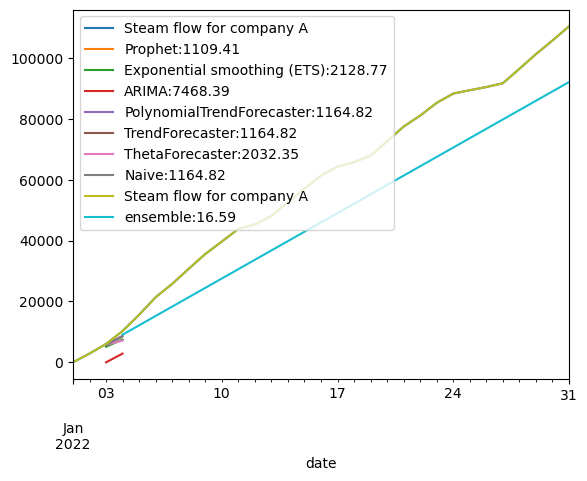

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Prophet', 'Naive', 'PolynomialTrendForecaster']


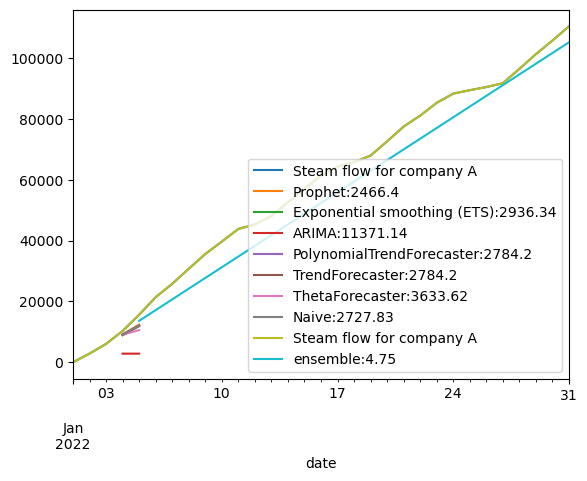

['Prophet', 'Naive', 'Exponential smoothing (ETS)']022-01-01 | end_date: 2022-01-03 | valid: 2022-01-04~2022-01-05 |fh: 26 | until: 2022-01-01~2022-01-31


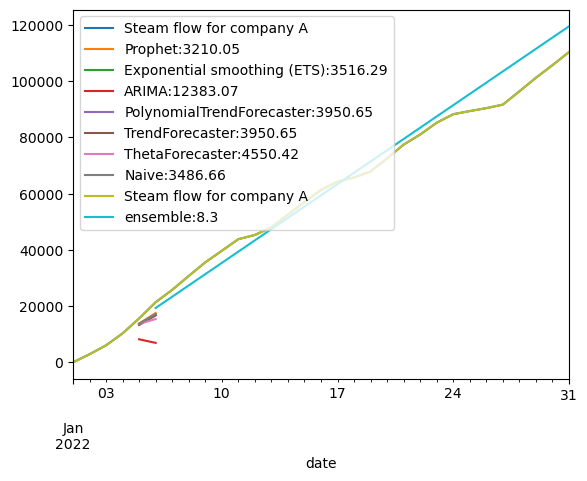

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Naive', 'Prophet', 'Exponential smoothing (ETS)']


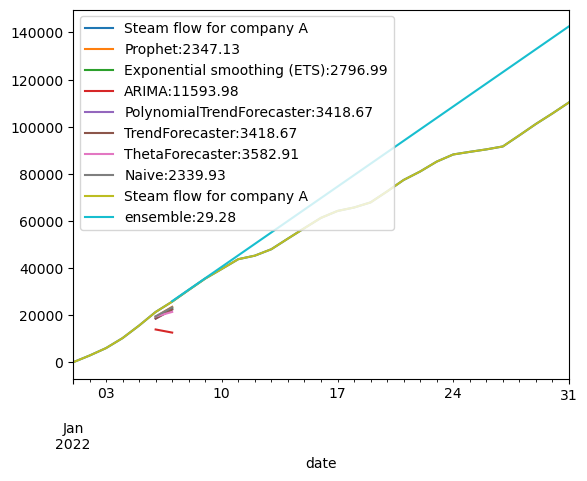

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Naive', 'Prophet', 'ThetaForecaster']


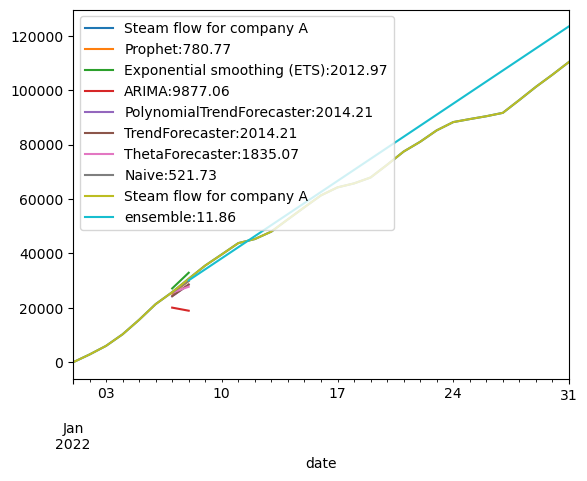

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'Exponential smoothing (ETS)', 'Naive']


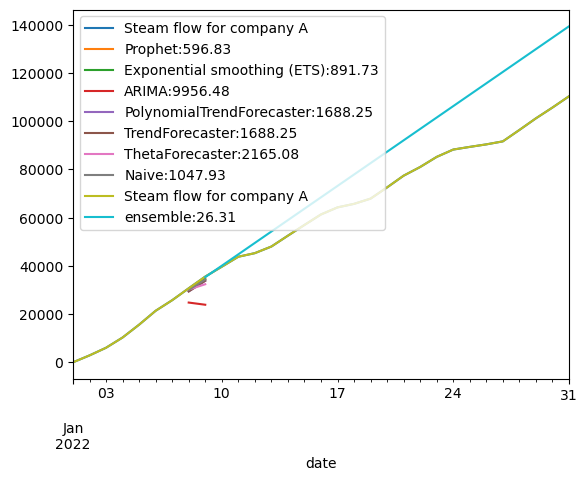

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Naive', 'Prophet', 'Exponential smoothing (ETS)']


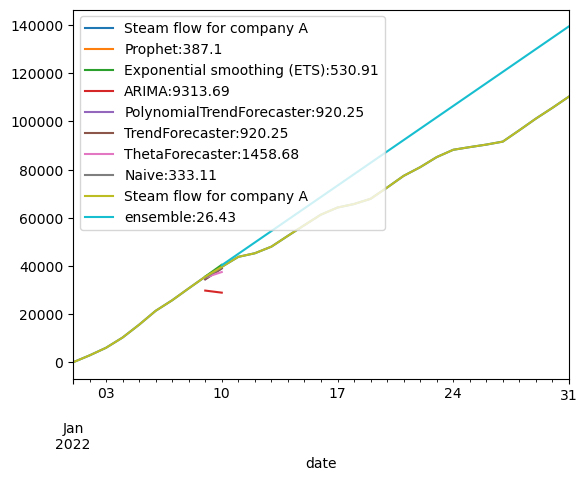

['PolynomialTrendForecaster', 'TrendForecaster', 'Naive']1-01 | end_date: 2022-01-08 | valid: 2022-01-09~2022-01-10 |fh: 21 | until: 2022-01-01~2022-01-31


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


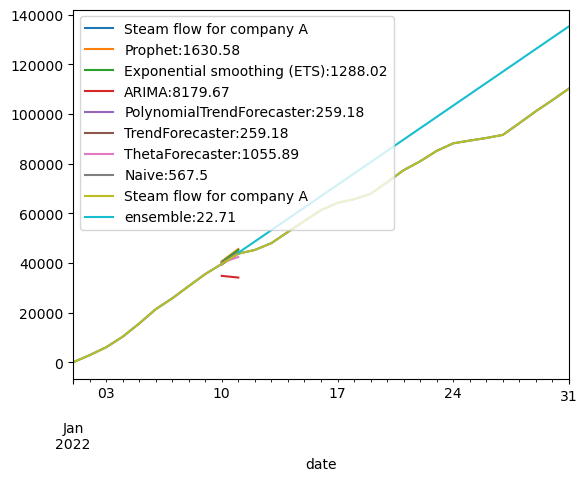

['ThetaForecaster', 'Naive', 'Exponential smoothing (ETS)']-01 | end_date: 2022-01-09 | valid: 2022-01-10~2022-01-11 |fh: 20 | until: 2022-01-01~2022-01-31


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


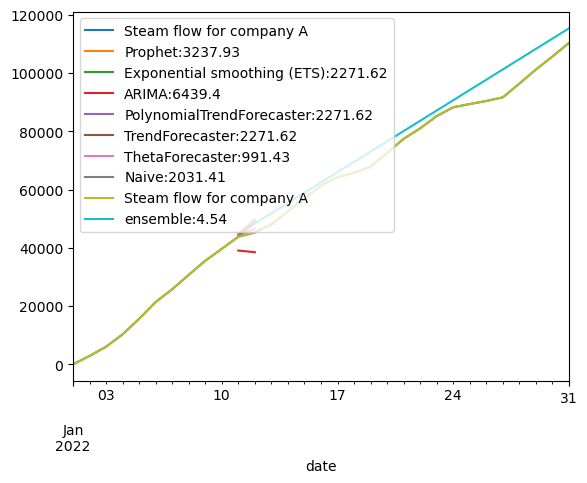

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['ThetaForecaster', 'Naive', 'Exponential smoothing (ETS)']


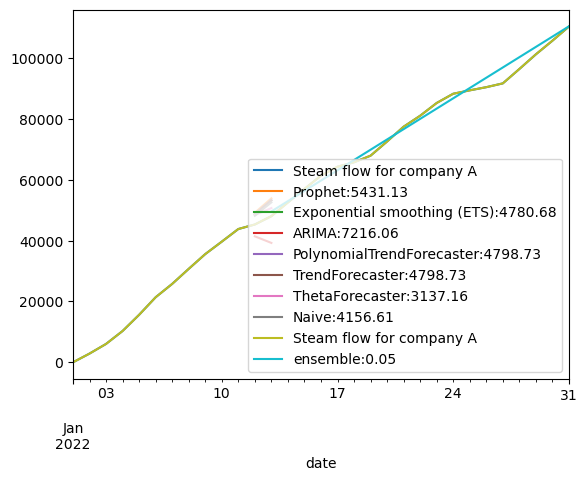

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['ThetaForecaster', 'Naive', 'Exponential smoothing (ETS)']


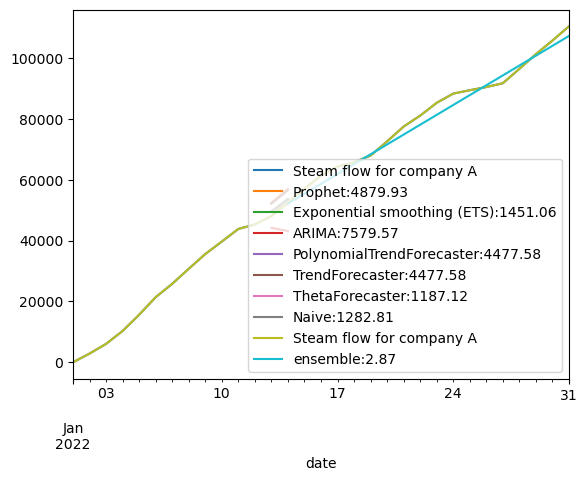

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'Naive', 'Exponential smoothing (ETS)']


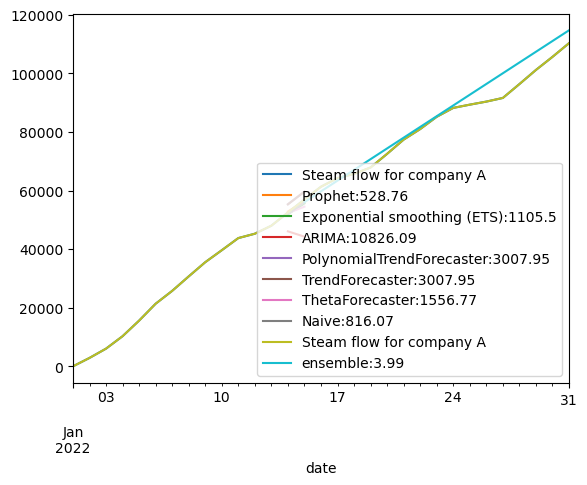

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Naive', 'Exponential smoothing (ETS)', 'ThetaForecaster']


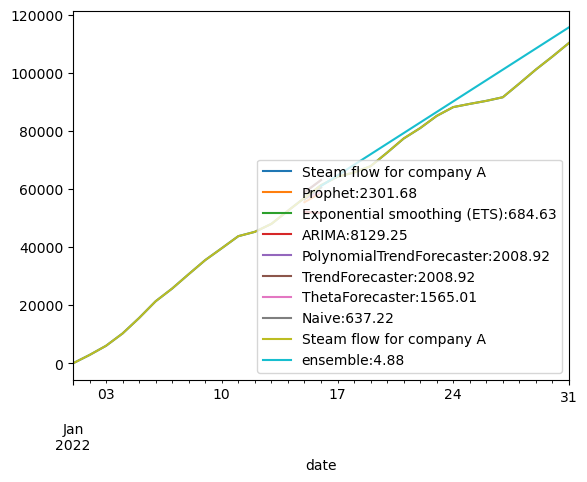

['Naive', 'Exponential smoothing (ETS)', 'ThetaForecaster']01 | end_date: 2022-01-14 | valid: 2022-01-15~2022-01-16 |fh: 15 | until: 2022-01-01~2022-01-31


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


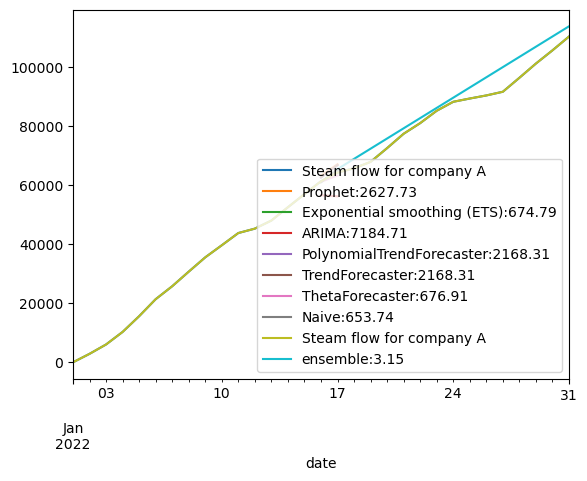

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['ThetaForecaster', 'Naive', 'Prophet']


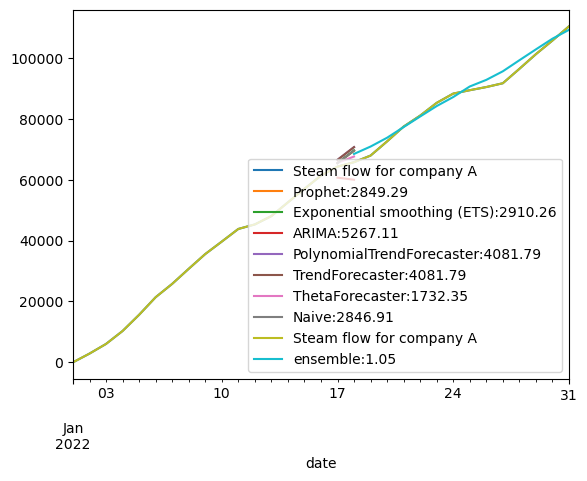

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'ThetaForecaster', 'Exponential smoothing (ETS)']


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


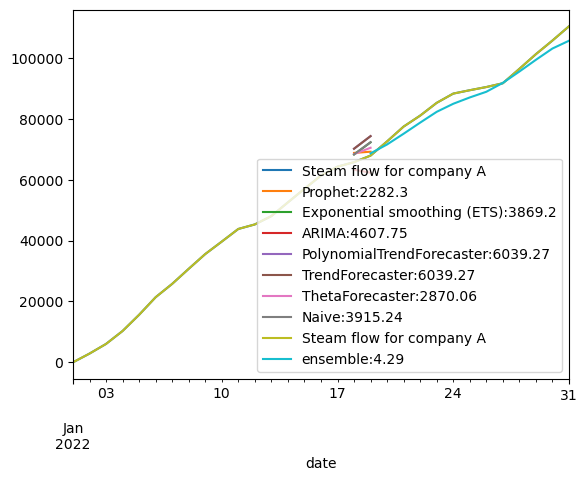

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Exponential smoothing (ETS)', 'Naive', 'ThetaForecaster']


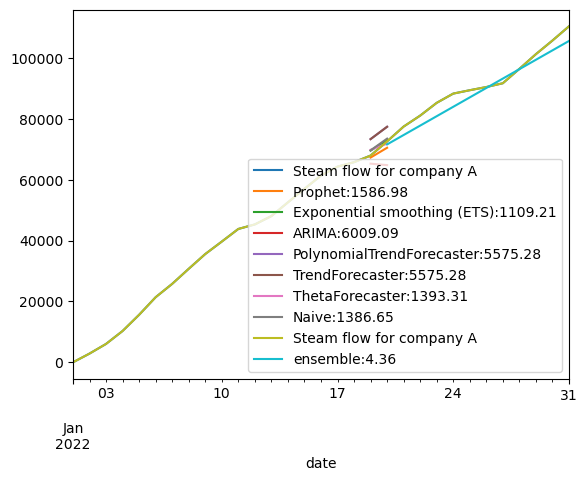

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Naive', 'Prophet', 'Exponential smoothing (ETS)']


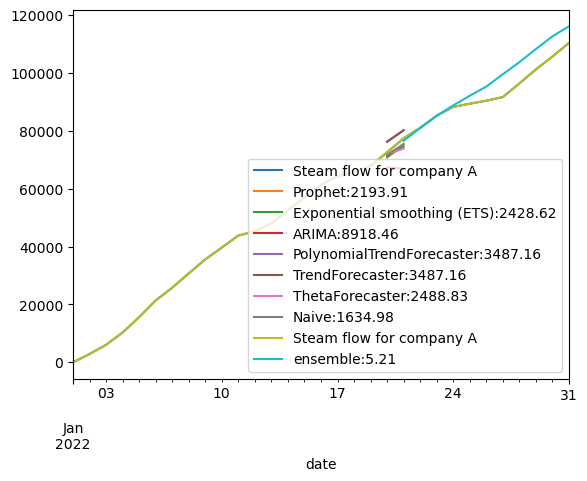

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'Exponential smoothing (ETS)', 'Naive']


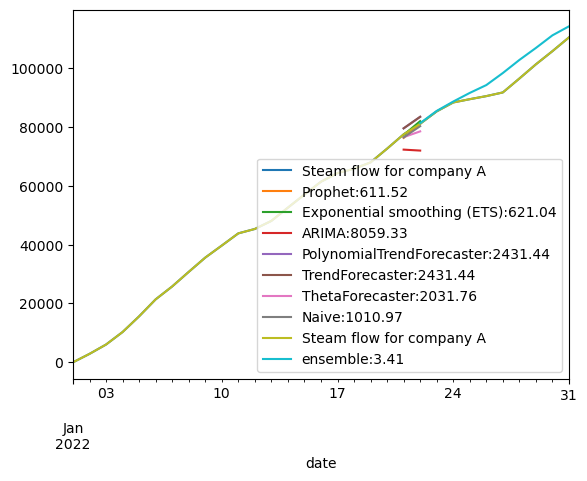

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Naive', 'Exponential smoothing (ETS)', 'Prophet']


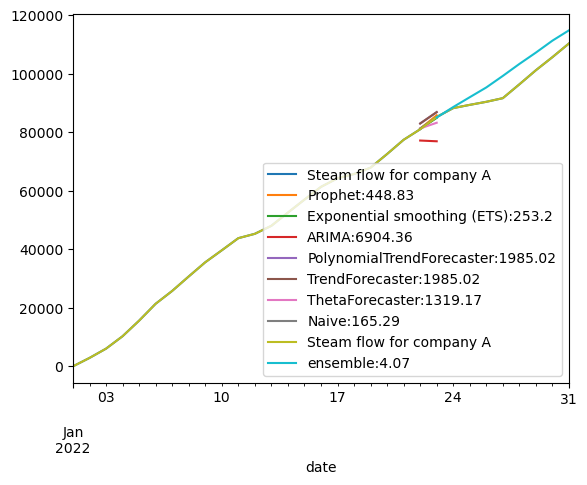

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Exponential smoothing (ETS)', 'Naive', 'Prophet']


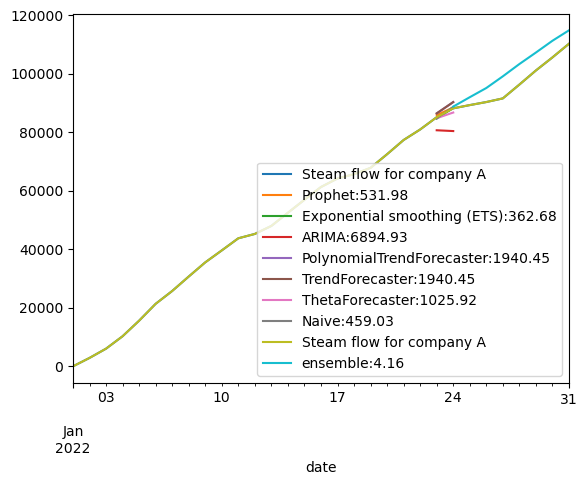

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'ThetaForecaster', 'Exponential smoothing (ETS)']


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


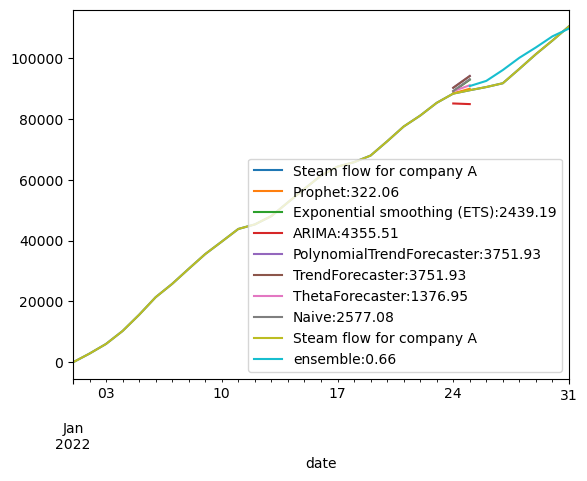

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'ARIMA', 'ThetaForecaster']


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


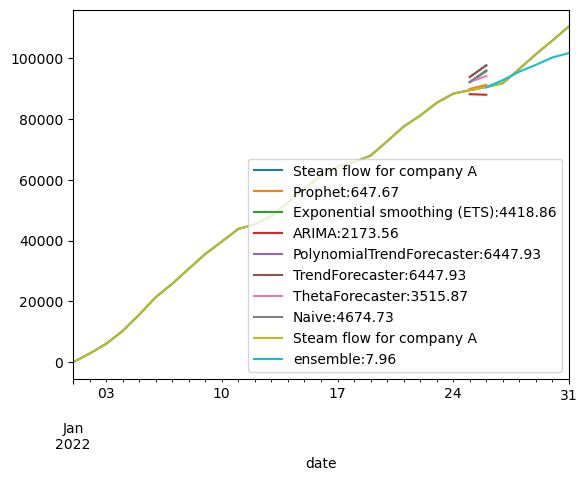

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'ThetaForecaster', 'ARIMA']


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


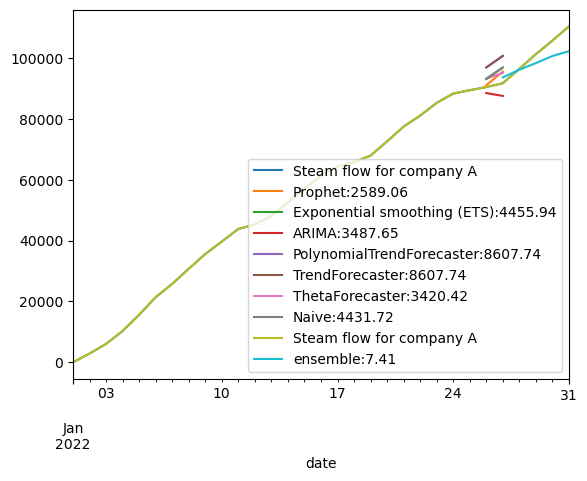

['Exponential smoothing (ETS)', 'ThetaForecaster', 'Naive']01 | end_date: 2022-01-25 | valid: 2022-01-26~2022-01-27 |fh: 4 | until: 2022-01-01~2022-01-31


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


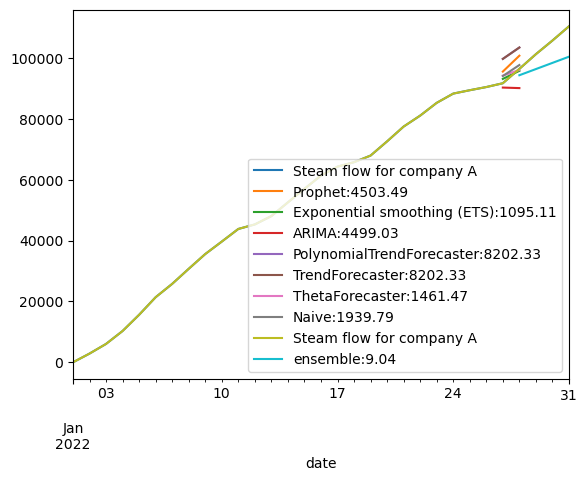

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'Naive', 'ThetaForecaster']


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


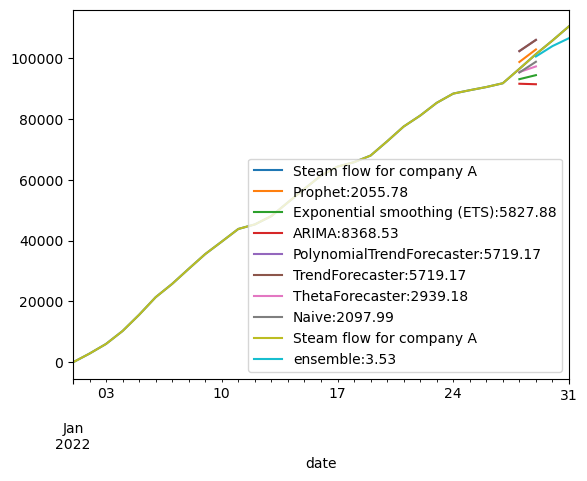

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'Naive', 'ThetaForecaster']


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


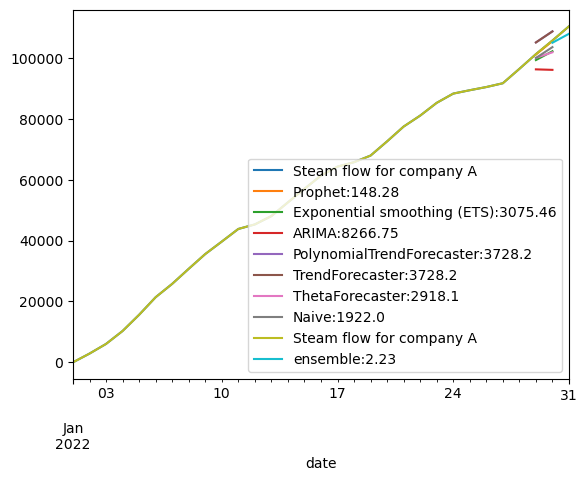

In [12]:
_, bo_result = A_forecasting(x, month_list=[1], fig=True)

In [13]:
compare_table['Proposed'] = bo_result
compare_table

Prophet  Croston  Exponential smoothing (ETS)  ARIMA  \
0     21.20    99.73                        34.59  99.97   
1     13.98    99.21                        19.80  97.41   
2      0.11    98.35                         4.01  95.51   
3     13.72    97.10                         4.75  93.18   
4     24.15    95.46                        50.03  90.18   
5     26.08    93.57                        18.73  86.68   
6     27.41    91.43                        29.73  82.87   
7     31.73    89.07                        29.21  77.36   
8     28.20    86.57                        23.63  72.44   
9     25.85    83.94                        23.15  80.56   
10    21.59    81.44                        12.52  71.87   
11     2.00    78.94                         4.44  75.37   
12     3.06    76.29                         9.69  57.49   
13    10.76    73.50                        11.13  53.31   
14     6.36    70.59                        11.85  52.52   
15     2.86    67.70                         8.82  52.76   
16     0.06    64.98                         1.42  45.78   
17     0.48    62.33                         2.71  43.65   
18     1.47    59.52                        12.28  37.38   
19     1.86    56.55                         4.11  32.08   
20     2.30    53.55                         3.77  28.74   
21     1.88    50.47                         4.73  24.24   
22     1.89    47.43                         3.32  21.23   
23     1.71    44.59                         1.31  23.90   
24     1.57    41.93                         6.01  18.85   
25     0.34    39.43                        12.13  17.53   
26     2.15    36.76                         4.79  13.10   
27     2.49    33.91                         0.46   8.81   

    PolynomialTrendForecaster  TrendForecaster  ThetaForecaster  Naive  \
0                       22.06            22.06            58.43  22.06   
1                       17.92            17.92            54.83  17.88   
2                        7.75             7.75            47.50   6.78   
3                        4.35             4.35            38.59   6.10   
4                       14.84            14.84            30.37  16.24   
5                       18.86            18.86            26.54  16.74   
6                       21.62            21.62            22.89  19.26   
7                       23.42            23.42            19.80  20.83   
8                       23.63            23.63            18.09  19.77   
9                       23.22            23.22            16.58  19.06   
10                      20.11            20.11            18.47  11.93   
11                      16.89            16.89            19.17   8.81   
12                      15.01            15.01            17.72   9.86   
13                      13.91            13.91            15.98  10.64   
14                      13.27            13.27            14.14  11.17   
15                      12.27            12.27            13.66   9.20   
16                      10.54            10.54            14.70   5.12   
17                       8.66             8.66            15.07   2.55   
18                       7.52             7.52            12.94   3.83   
19                       6.96             6.96            10.45   5.25   
20                       6.46             6.46             9.05   4.89   
21                       6.17             6.17             7.06   5.31   
22                       5.77             5.77             6.12   4.32   
23                       4.96             4.96             6.97   1.23   
24                       3.86             3.86             7.90   1.69   
25                       2.62             2.62             8.61   4.16   
26                       1.79             1.79             6.09   2.96   
27                       1.28             1.28             3.40   1.73   

    Proposed  
0      21.76  
1      16.59  
2       4.75  
3       8.30  
4      29.28  
5      11.86  
6      26.3

<Axes: >

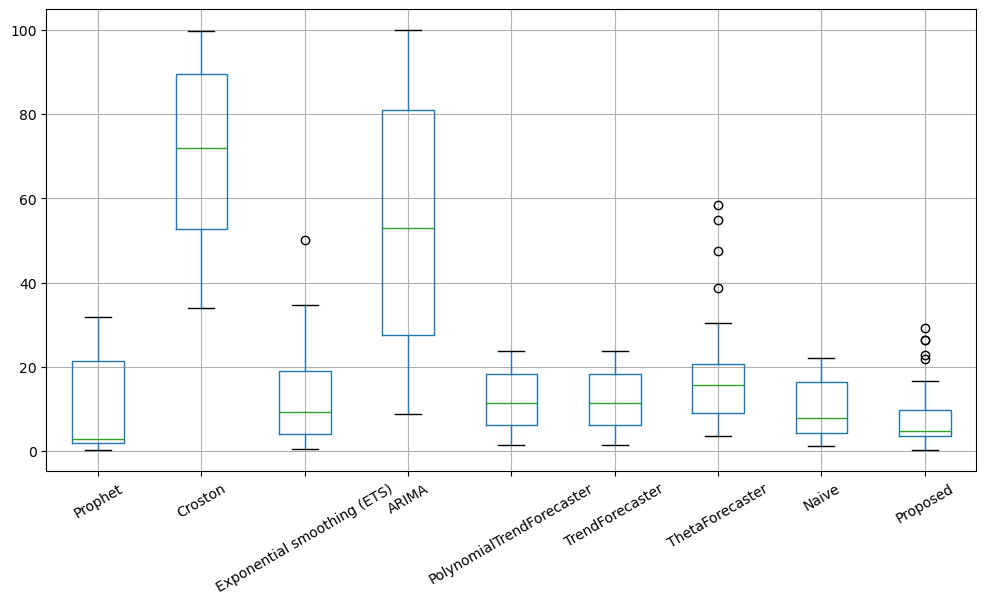

In [14]:
compare_table.boxplot(rot=30, figsize=(12,6))

In [15]:


# x = [8, 1.3, 4 ] # past_ob_n, discount_factor, n_e
# performance_score, final_result = A_forecasting(x)
# performance_score, final_result



c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Prophet', 'Exponential smoothing (ETS)', 'PolynomialTrendForecaster']


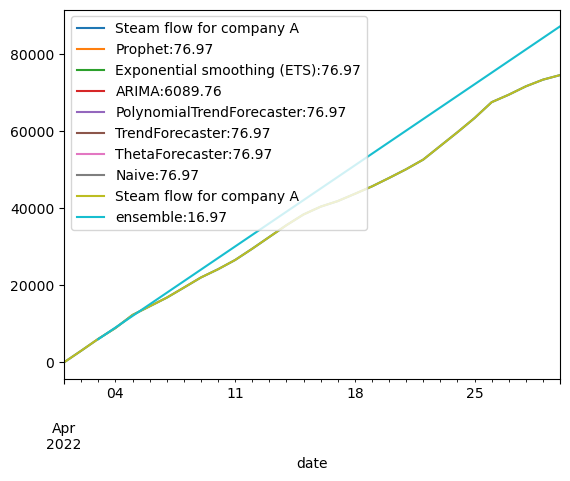

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Prophet', 'Exponential smoothing (ETS)', 'PolynomialTrendForecaster']


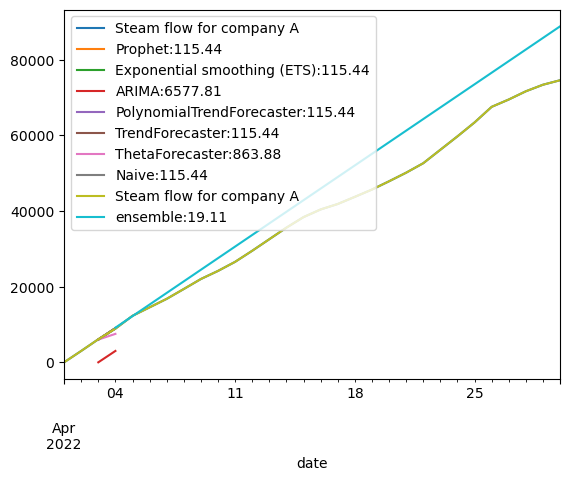

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Prophet', 'Exponential smoothing (ETS)', 'Naive']


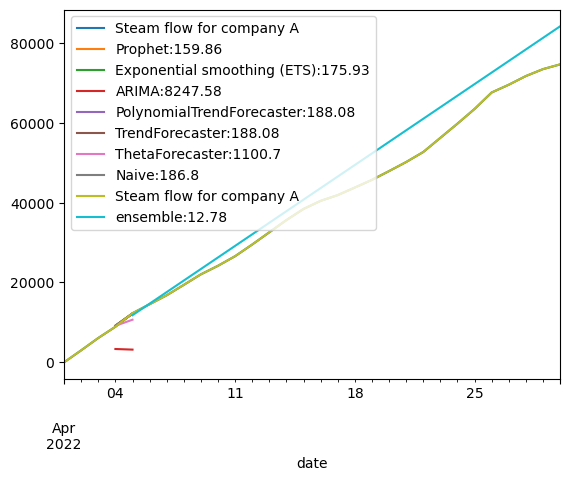

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['Prophet', 'Exponential smoothing (ETS)', 'Naive']


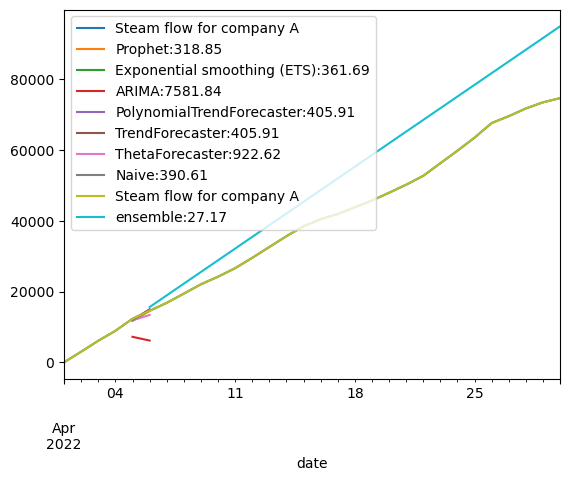

['ThetaForecaster', 'PolynomialTrendForecaster', 'TrendForecaster']_date: 2022-04-04 | valid: 2022-04-05~2022-04-06 |fh: 24 | until: 2022-04-01~2022-04-30


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


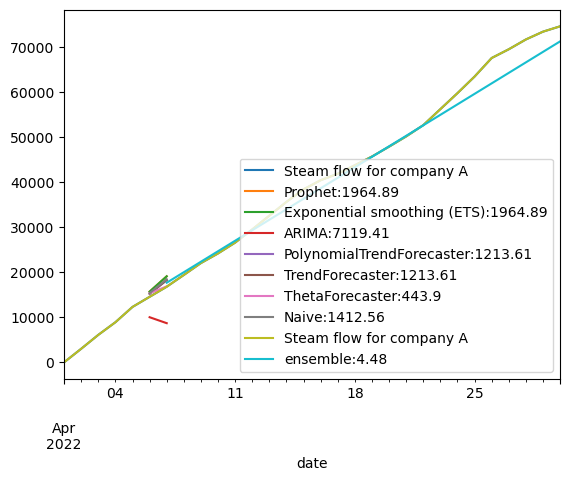

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Exponential smoothing (ETS)', 'ThetaForecaster', 'Naive']


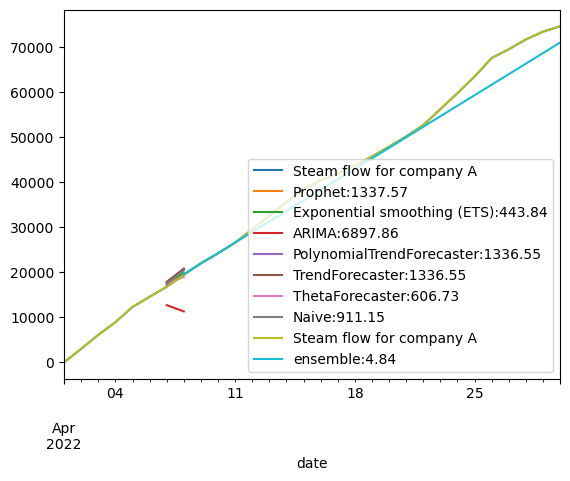

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Exponential smoothing (ETS)', 'Naive', 'Prophet']


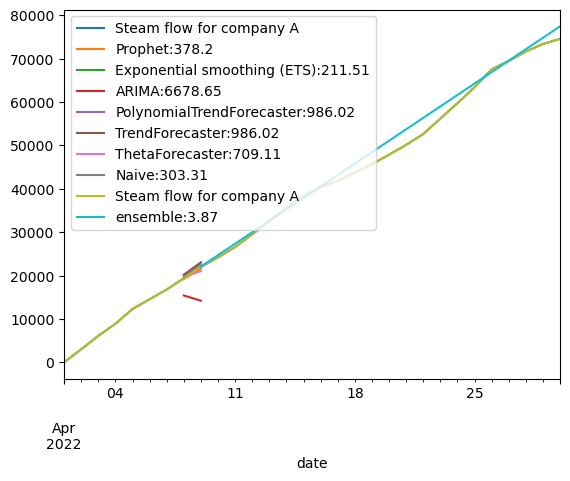

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'ThetaForecaster', 'Exponential smoothing (ETS)']


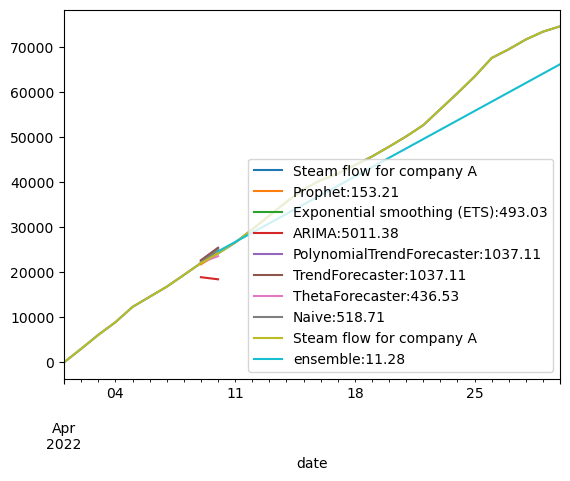

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'ThetaForecaster', 'Exponential smoothing (ETS)']


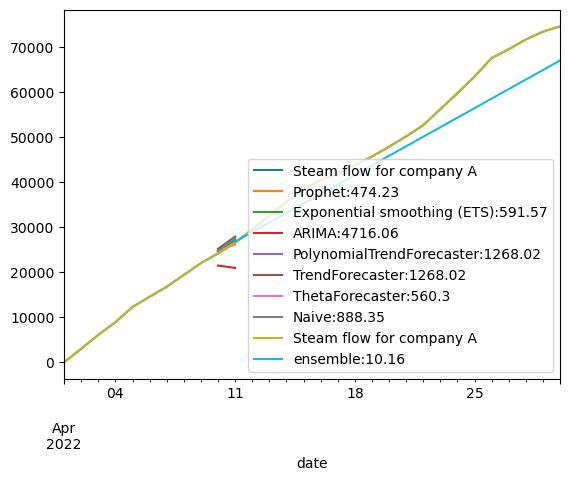

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Exponential smoothing (ETS)', 'Naive', 'Prophet']


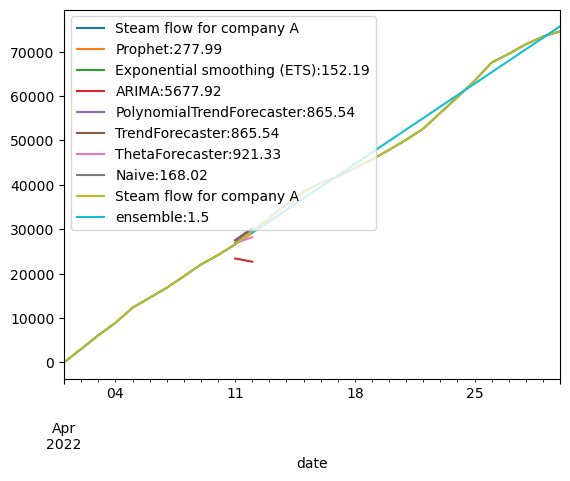

['PolynomialTrendForecaster', 'TrendForecaster', 'Naive']-01 | end_date: 2022-04-10 | valid: 2022-04-11~2022-04-12 |fh: 18 | until: 2022-04-01~2022-04-30


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


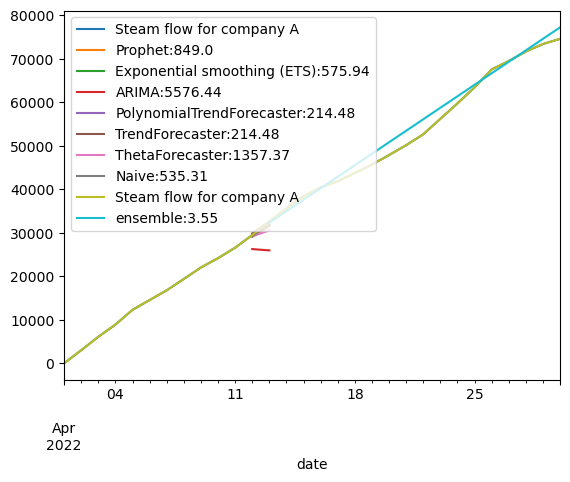

['PolynomialTrendForecaster', 'TrendForecaster', 'Naive']4-01 | end_date: 2022-04-11 | valid: 2022-04-12~2022-04-13 |fh: 17 | until: 2022-04-01~2022-04-30


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


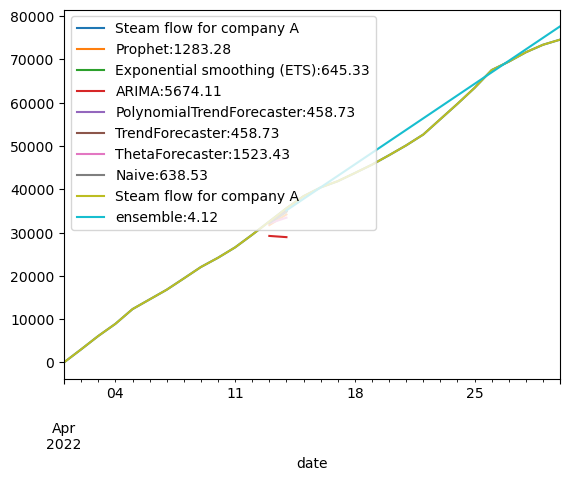

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Naive', 'Exponential smoothing (ETS)', 'PolynomialTrendForecaster']


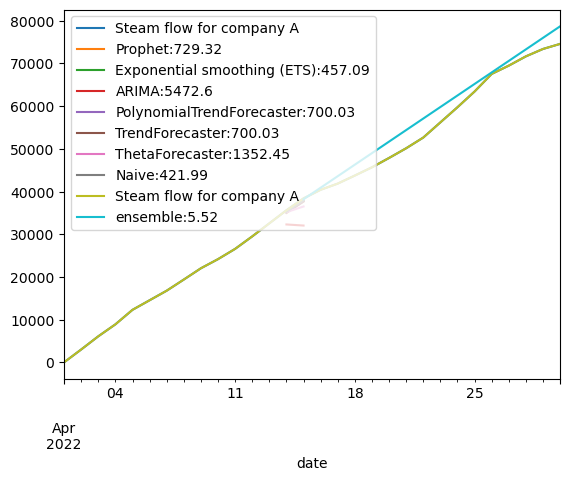

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['PolynomialTrendForecaster', 'TrendForecaster', 'Exponential smoothing (ETS)']


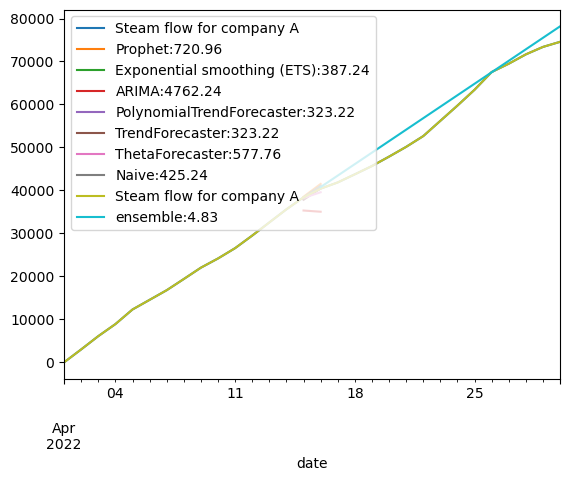

['ThetaForecaster', 'PolynomialTrendForecaster', 'TrendForecaster']_date: 2022-04-14 | valid: 2022-04-15~2022-04-16 |fh: 14 | until: 2022-04-01~2022-04-30


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


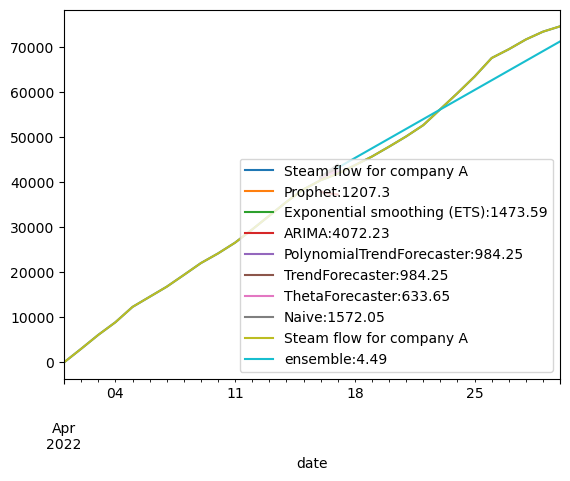

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'ThetaForecaster', 'Exponential smoothing (ETS)']


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


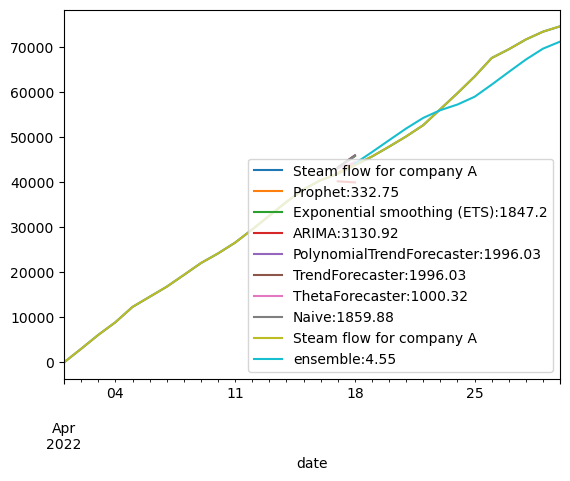

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['ThetaForecaster', 'Prophet', 'Exponential smoothing (ETS)']


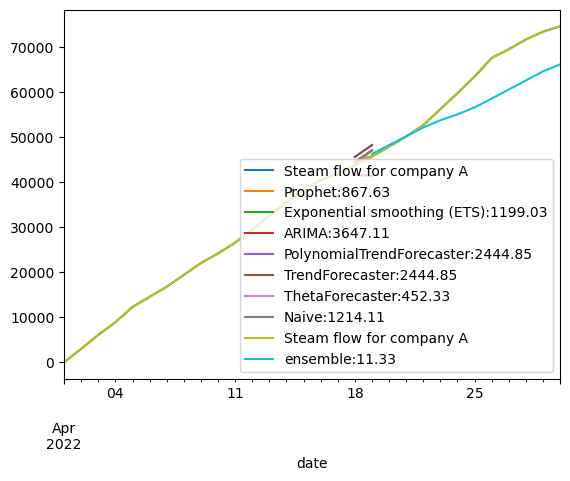

['Exponential smoothing (ETS)', 'ThetaForecaster', 'Naive']-01 | end_date: 2022-04-17 | valid: 2022-04-18~2022-04-19 |fh: 11 | until: 2022-04-01~2022-04-30


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


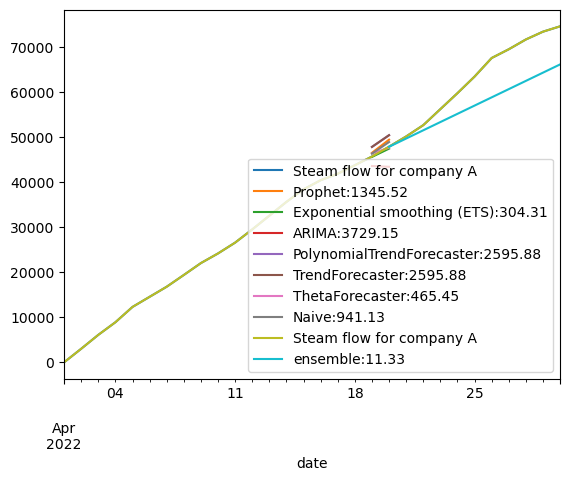

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'Naive', 'ThetaForecaster']


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


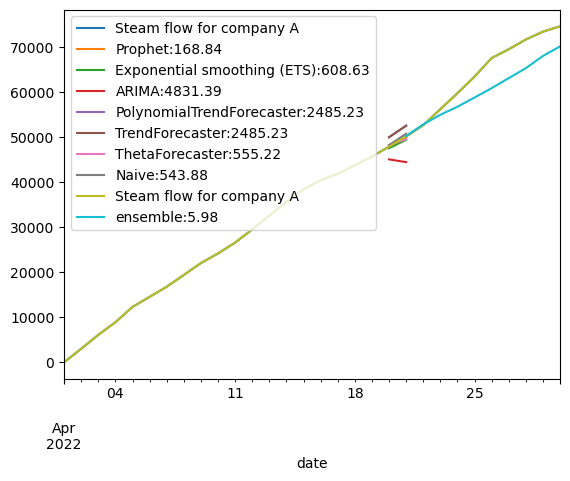

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Naive', 'Prophet', 'Exponential smoothing (ETS)']


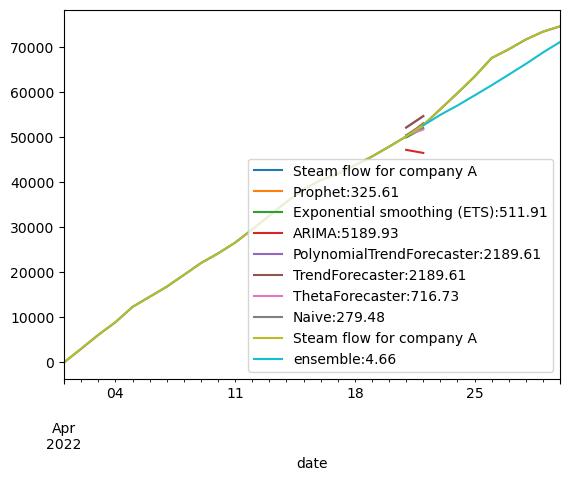

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Naive', 'Prophet', 'Exponential smoothing (ETS)']


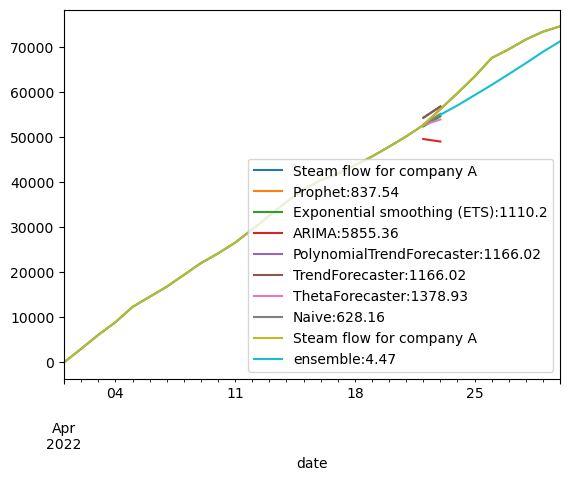

['PolynomialTrendForecaster', 'TrendForecaster', 'Naive']4-01 | end_date: 2022-04-21 | valid: 2022-04-22~2022-04-23 |fh: 7 | until: 2022-04-01~2022-04-30


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


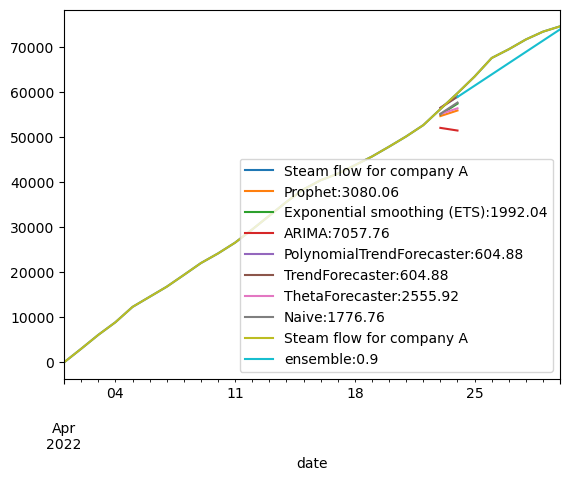

['Exponential smoothing (ETS)', 'PolynomialTrendForecaster', 'TrendForecaster']4-22 | valid: 2022-04-23~2022-04-24 |fh: 6 | until: 2022-04-01~2022-04-30


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


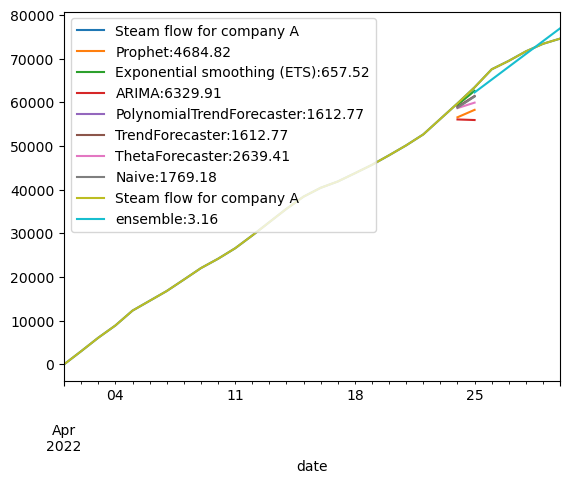

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Exponential smoothing (ETS)', 'Naive', 'PolynomialTrendForecaster']


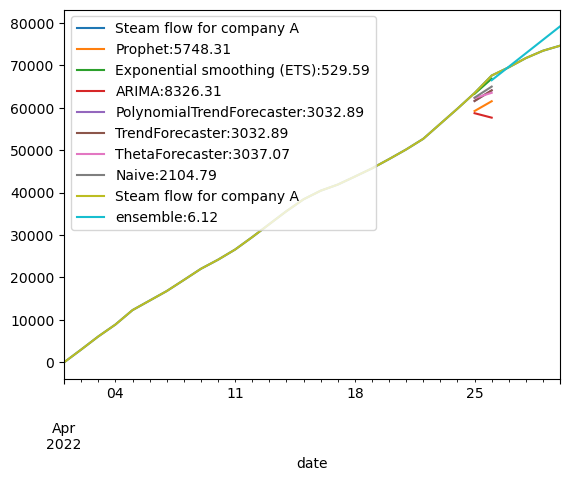

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'Exponential smoothing (ETS)', 'Naive']


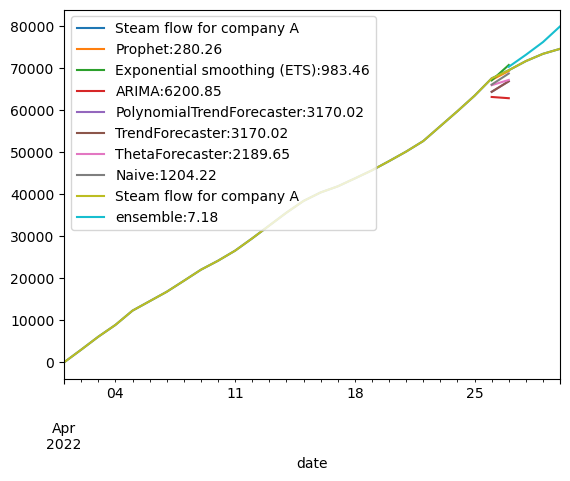

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['Prophet', 'ThetaForecaster', 'Naive']


c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


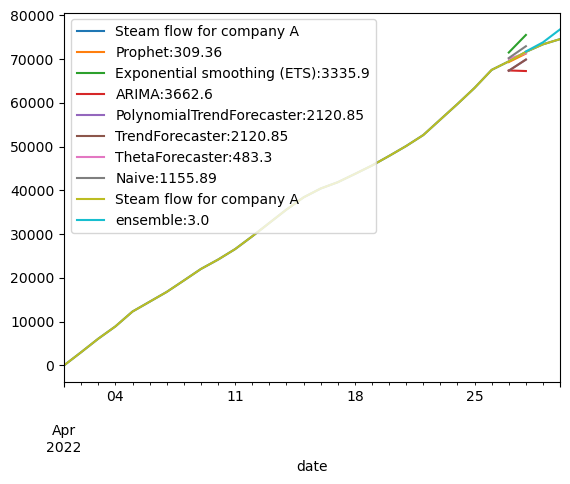

c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\PC\.conda\envs\pycaret_3.11\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


['ThetaForecaster', 'Prophet', 'PolynomialTrendForecaster']


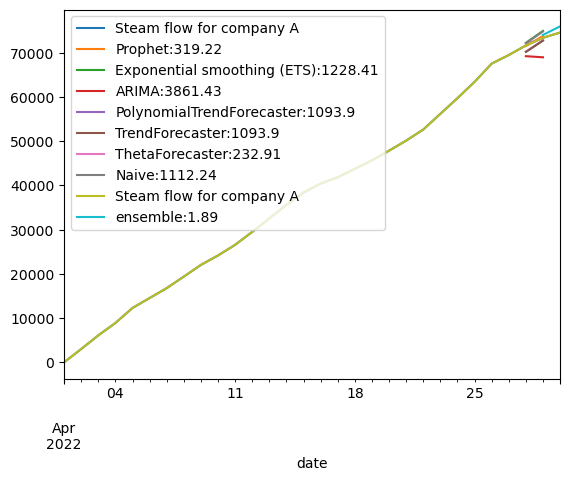

(7.37925925925926,
 [16.97,
  19.11,
  12.78,
  27.17,
  4.48,
  4.84,
  3.87,
  11.28,
  10.16,
  1.5,
  3.55,
  4.12,
  5.52,
  4.83,
  4.49,
  4.55,
  11.33,
  11.33,
  5.98,
  4.66,
  4.47,
  0.9,
  3.16,
  6.12,
  7.18,
  3.0,
  1.89])

In [16]:
A_forecasting([2, 1.2, 3],month_list=[4], fig=True)

In [533]:
y_pred

2022-01-18     68380.586819
2022-01-19     72158.763293
2022-01-20     75936.939767
2022-01-21     79715.116242
2022-01-22     83493.292716
2022-01-23     87271.469191
2022-01-24     91049.645665
2022-01-25     94827.822139
2022-01-26     98605.998614
2022-01-27    102384.175088
2022-01-28    106162.351563
2022-01-29    109940.528037
2022-01-30    113718.704511
2022-01-31    117496.880986
Freq: D, Name: cum, dtype: float64

In [531]:
y_true

date
2022-01-18     65714.029362
2022-01-19     67882.194241
2022-01-20     72546.626157
2022-01-21     77403.553894
2022-01-22     81000.831335
2022-01-23     85191.322367
2022-01-24     88227.281577
2022-01-25     89336.411536
2022-01-26     90378.999793
2022-01-27     91626.743229
2022-01-28     96347.928904
2022-01-29    101172.820797
2022-01-30    105639.944548
2022-01-31    110311.802396
Freq: D, Name: cum, dtype: float64

10:18:58 - cmdstanpy - INFO - Chain [1] start processing


10:19:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet:8011.540537929345
PolynomialTrendForecaster:2393.7316690835014


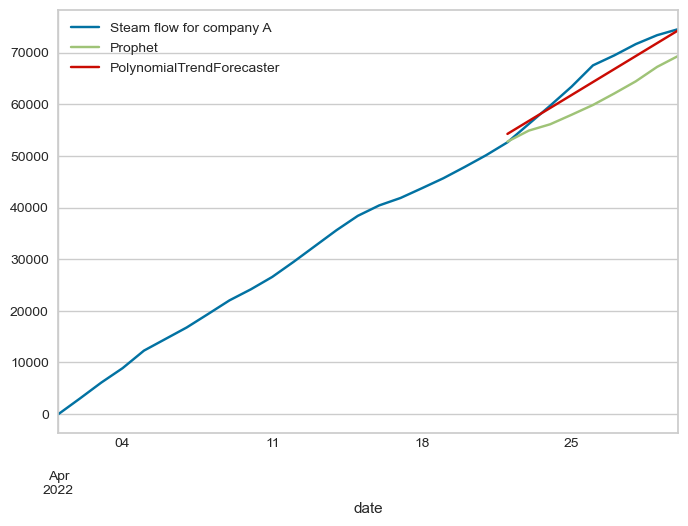

In [356]:
y = df_ts_1m['cum'].loc[start_date:ob_date]
y_true = df_ts_1m['cum'].loc[ob_date+datetime.timedelta(days=1):end_date]

model_nm = 'Prophet'
# Prophet requires to have data with a pandas.DatetimeIndex
forecaster = Prophet(  
    seasonality_mode='multiplicative',
    # n_changepoints=int(len(y) / 13),
    add_country_holidays={'country_name': 'Korea'},
    # yearly_seasonality=True
    )
forecaster.fit(y)  
y_pred = forecaster.predict(fh=range(1,test_fh))  
y_pred_int = forecaster.predict_interval(coverage=0.9)
y_pred_int
# fig, ax = plotting.plot_series(
#     y, y_pred, labels=['Steam flow for company A', "Prophet"], pred_interval=y_pred_int
# )

ax = df_ts_1m['cum'].loc[init_date:end_date].plot(label='Steam flow for company A')#'2022-01-26 00:00:00'
valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
print(f'{model_nm}:{valid_val}')
y_pred.plot(ax=ax, label=model_nm)




model_nm = 'PolynomialTrendForecaster'
forecaster = PolynomialTrendForecaster()  
forecaster.fit(y)  
y_pred = forecaster.predict(fh=range(1,test_fh))  
valid_val = discount_mae_fun(y_true, y_pred, discount_factor)
print(f'{model_nm}:{valid_val}')
y_pred.plot(ax=ax, label=model_nm)

ax.legend()


# BO 로 parameter 찾기
- Maximum number of chosen models (1,10)

    (1) Prophet, 
    (2) Exponential smoothing (ETS), 
    (3) Naive, 
    (4) Polynomial Trend forecaster, 
    (5) ARIMA, 
    (6) Theta forecaster, 
    (7) Auto ARIMA, 
    (8) TrendForecaster,
    (9) UnobservedComponents,
    (10) Croston



- Discount factor of past observations (1, 1.5)
- Size of past observations to evaluate (1,30)

In [9]:
# #maximize TVP & minimize CO2
# df = df.rename(columns=column_dict)    
# cost_co2_result = []
# lng_price_list = [ round(999.52*0.80, 3), round(999.52*0.85, 3)] #999.52, 999.52*1.05, 999.52*1.1, round(999.52*1.15, 3)]#, 999.52, round(999.52*0.90, 3), round(999.52*0.95, 3)
# co2_reduction_rate_list = [0.76, 0.78, 0.80, 0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1]
# co2_reduction_rate_list = [0.72, 0.74, 0.76,0.78,0.80,0.82,0.84,0.86,0.88, 0.90,0.92,0.94,0.96,0.98,1]
# co2_reduction_rate_list = [0.72, 0.73,0.74, 0.75,0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82,0.83, 0.84,0.85, 0.86,0.87, 0.88,0.89, 0.90,0.91, 0.92,0.93, 0.94,0.95, 0.96,0.97, 0.98,0.99, 1]
# co2_reduction_rate_list = [0.72, 0.74, 0.76,0.78,0.80,0.82,0.84,0.86,0.88, 0.90,0.92,0.94,0.96,0.98,1]
# tvp_increasing_rate_list = [1]
# co2_reduction_rate_list = [0.90]


# co2_price = 15000
# bc_price = 1015
# lng_price=round(990)

# for month in [1, 2, 3, 4, 5, 6, 7]:#, 8, 9, 10, 11, 12]: 
#     for tvp_increasing_rate in tvp_increasing_rate_list:
#         #lng_price = 999.52
#         for co2_reduction_rate in co2_reduction_rate_list:
#             print(f'opt_qty_{month}_{int(co2_reduction_rate*100)}_{lng_price}_{tvp_increasing_rate}')
#             df['month'] = df['date'].apply(lambda x: x.split('-')[1].zfill(2))

#             input_dict = {}
#             input_dict['year'] = 2022
#             input_dict['month'] = month
#             input_dict['time_interval'] = 5 #min
#             year = input_dict['year']
#             month = input_dict['month']
#             time_interval = input_dict['time_interval']

#             import datetime
#             schedule_info = pd.read_csv('schedule_none.csv')
#             total_qty_real = 0
#             opt_qty_list = []

#             price = PRICE(bc_price, lng_price, co2_price)
#             df_month = df[df.month==str(month).zfill(2)].reset_index(drop=True)
#             last_day = (datetime.date(year, int(month)+1, 1) - datetime.timedelta(days=1)).day
#             total_number_of_opt_in_month = last_day*24*(60/time_interval)

#             co2_em_LNG = price.co2_em(type='LNG')
#             co2_em_bc = price.co2_em(type='bc')
#             co2_em_waste = price.co2_em(type='waste')

#             A_qty_real = 0
#             B_qty_total = 0
#             C_qty_total = 0
#             S20T_qty_total = 0
#             S50T_qty_total = 0
#             co2_total = 0
#             count_index = 1

#             for check_index in df_month.index:
#                 # dcs data
#                 dcs_data = df_month.iloc[check_index]
#                 # try:
#                 total_demand, solution = run(price, dcs_data, schedule_info, co2_reduction_rate, tvp_increasing_rate)
                
#                 #------------------------------------------------------------------------------
#                 percent_done = (count_index)/total_number_of_opt_in_month*100
#                 percent_done = round(percent_done, 1)
#                 bar_len = 30
#                 done = round(percent_done/(100/bar_len))
#                 togo = bar_len-done
#                 done_str = '█'*int(done)
#                 togo_str = '░'*int(togo)
            
#                 A_qty = (solution['x_A1']+solution['x_A2']+solution['x_A3']+solution['x_A4'])
#                 B_qty = solution['x_B']
#                 C_qty = solution['x_C']
#                 S20T_qty = solution['x_S20T']
#                 S50T_qty = solution['x_S50T']
#                 A_co2_qty = A_qty*co2_em_LNG
#                 B_co2_qty = B_qty*co2_em_bc
#                 C_co2_qty = C_qty*co2_em_waste
#                 S_co2_qty = (S20T_qty+S50T_qty)*co2_em_LNG
#                 co2_em = (A_co2_qty+B_co2_qty+C_co2_qty+S_co2_qty)*5/60
#                 co2_total += co2_em
#                 total_qty = A_qty+B_qty+C_qty+S20T_qty+S50T_qty

#                 total_qty_real += total_qty*5/60########################## DCS 사용 시 tracking 필요
#                 opt_qty_list.append([A_qty, B_qty, C_qty, S50T_qty, S20T_qty, total_demand])

#                 #|total supply: {round(total_supply, 1)}, total demand: {round(total_demand, 1)}
#                 print(f'\t⏳ progress: [{done_str}{togo_str}] {percent_done}% |CO2: {round(co2_total, 1)}|total qty: {round(total_qty_real,1)} |A: {round(A_qty)},  B: {round(B_qty, 1)}, C: {round(C_qty, 1)}, S20T: {round(S20T_qty, 1)}, S50T: {round(S50T_qty, 1)}', end='\r')
#                 # except:
#                 #     print('fail')
#                 #     break

#                 if count_index == total_number_of_opt_in_month:
#                     print('\t✅')
#                     df_month = df[df.month==str(month).zfill(2)].reset_index(drop=True)
#                     org_qty_df = df_month[['A사 유량', 'B사 유량', 'C사 유량', '50톤 보일러 유량', '20톤 보일러 유량']]
#                     org_qty_df.columns = ['A', 'B', 'C', 'S50T', 'S20T' ]
#                     org_qty_df['total'] = org_qty_df.apply(lambda x: x.sum(), axis=1)

#                     def A_price_func(x):
#                         if x <10:
#                             A_price = 57*lng_price
#                         elif (10<=x) & (x<20):
#                             A_price = 55*lng_price
#                         elif (20<=x) & (x<30):
#                             A_price = 53*lng_price
#                         elif 30<=x:
#                             A_price = 50*lng_price
#                         return A_price

#                     total_org_qty = round(org_qty_df[['total']].apply(lambda x: x.sum()*5/60, axis=0)/10000, 1)

#                     # A_co2 = org_qty_df['A'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
#                     # B_co2 = org_qty_df['B'].apply(lambda x: x*price.co2_em(type='bc')*5/60)
#                     # C_co2 = org_qty_df['C'].apply(lambda x: x*price.co2_em(type='waste')*5/60)
#                     # S20T_co2 = org_qty_df['S20T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
#                     # S50T_co2 = org_qty_df['S50T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
#                     # co2_df = pd.DataFrame()
#                     # co2_df['A_co2'] = A_co2
#                     # co2_df['B_co2'] = B_co2
#                     # co2_df['C_co2'] = C_co2
#                     # co2_df['S50T_co2'] = S50T_co2
#                     # co2_df['S20T_co2'] = S20T_co2
#                     # co2_df['total'] = co2_df.apply(lambda x: x.sum(), axis=1)
#                     # org_co2_df = co2_df
#                     # org_co2_df.apply(lambda x: x.sum(), axis=0)

#                     opt_qty_df = pd.DataFrame(opt_qty_list, columns=['A', 'B', 'C', 'S50T', 'S20T','total_demand'])
#                     org_qty_df.to_csv(os.path.join('final_report_result',f'org_qty_{month}_{int(co2_reduction_rate*100)}_{lng_price}_{tvp_increasing_rate}.csv'), index=False)
#                     opt_qty_df.to_csv(os.path.join('final_report_result',f'opt_qty_{month}_{int(co2_reduction_rate*100)}_{lng_price}_{tvp_increasing_rate}.csv'), index=False)

#                 #------------------------------------------------------------------------------
#                 count_index += 1



In [ ]:
total_result = {}
total_result['total_co2'] = {}
total_result['samyang_co2'] = {}

for month in [1, 2, 3, 4, 5, 6, 7]: #, 3, 4, 5, 6, 7
    for tvp_increasing_rate in tvp_increasing_rate_list:
        #lng_price = 999.52
        for co2_reduction_rate in co2_reduction_rate_list:
            org_qty_df =  pd.read_csv(os.path.join('final_report_result',f'org_qty_{month}_{int(co2_reduction_rate*100)}_{lng_price}_{tvp_increasing_rate}.csv'))
            A_co2 = org_qty_df['A'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
            B_co2 = org_qty_df['B'].apply(lambda x: x*price.co2_em(type='bc')*5/60)
            C_co2 = org_qty_df['C'].apply(lambda x: x*price.co2_em(type='waste')*5/60)
            S20T_co2 = org_qty_df['S20T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
            S50T_co2 = org_qty_df['S50T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
            co2_df = pd.DataFrame()
            co2_df['A_co2'] = A_co2
            co2_df['B_co2'] = B_co2
            co2_df['C_co2'] = C_co2
            co2_df['S50T_co2'] = S50T_co2
            co2_df['S20T_co2'] = S20T_co2
            co2_df['total'] = co2_df.apply(lambda x: x.sum(), axis=1)
            co2_df['samyang_co2'] = co2_df['S50T_co2'] +co2_df['S20T_co2']
            org_co2_df = co2_df
            org_co2_df.apply(lambda x: x.sum(), axis=0)
            org_co2_df
            total_co2_emission = org_co2_df['total'].sum()
            total_samyang_co2 = org_co2_df['samyang_co2'].sum()
            total_result['total_co2'][month] = total_co2_emission
            total_result['samyang_co2'][month] = total_samyang_co2
org_co2_result = total_result
org_co2_result


{'total_co2': {1: 194091.26149737398,
  2: 187235.87670235767,
  3: 167194.8897476424,
  4: 182088.71159157983,
  5: 175566.23931357072,
  6: 167606.44332687533,
  7: 182213.66395620597},
 'samyang_co2': {1: 57376.321574187,
  2: 46852.27350879874,
  3: 24428.87252477199,
  4: 39381.827792073185,
  5: 49543.82344318113,
  6: 33846.95286900065,
  7: 43241.95783246483}}

In [ ]:
total_result

{'total_co2': {1: 194091.26149737398,
  2: 187235.87670235767,
  3: 167194.8897476424,
  4: 182088.71159157983,
  5: 175566.23931357072,
  6: 167606.44332687533,
  7: 182213.66395620597},
 'samyang_co2': {1: 57376.321574187,
  2: 46852.27350879874,
  3: 24428.87252477199,
  4: 39381.827792073185,
  5: 49543.82344318113,
  6: 33846.95286900065,
  7: 43241.95783246483}}

In [ ]:
total_result = {}
total_result['total_co2'] = {}
total_result['samyang_co2'] = {}

for month in [1, 2, 3, 4, 5, 6, 7]: #, 3, 4, 5, 6, 7
    for tvp_increasing_rate in tvp_increasing_rate_list:
        #lng_price = 999.52
        for co2_reduction_rate in co2_reduction_rate_list:
            org_qty_df =  pd.read_csv(os.path.join('final_report_result',f'opt_qty_{month}_{int(co2_reduction_rate*100)}_{lng_price}_{tvp_increasing_rate}.csv'))
            A_co2 = org_qty_df['A'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
            B_co2 = org_qty_df['B'].apply(lambda x: x*price.co2_em(type='bc')*5/60)
            C_co2 = org_qty_df['C'].apply(lambda x: x*price.co2_em(type='waste')*5/60)
            S20T_co2 = org_qty_df['S20T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
            S50T_co2 = org_qty_df['S50T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
            co2_df = pd.DataFrame()
            co2_df['A_co2'] = A_co2
            co2_df['B_co2'] = B_co2
            co2_df['C_co2'] = C_co2
            co2_df['S50T_co2'] = S50T_co2
            co2_df['S20T_co2'] = S20T_co2
            co2_df['total'] = co2_df.apply(lambda x: x.sum(), axis=1)
            co2_df['samyang_co2'] = co2_df['S50T_co2'] +co2_df['S20T_co2']
            org_co2_df = co2_df
            org_co2_df.apply(lambda x: x.sum(), axis=0)
            org_co2_df
            total_co2_emission = org_co2_df['total'].sum()
            total_samyang_co2 = org_co2_df['samyang_co2'].sum()
            total_result['total_co2'][month] = total_co2_emission
            total_result['samyang_co2'][month] = total_samyang_co2
opt_co2_result = total_result
opt_co2_result


{'total_co2': {1: 169854.46241444428,
  2: 169758.9317516933,
  3: 146276.16952479107,
  4: 161330.3381925399,
  5: 157842.24476533078,
  6: 146069.03251530114,
  7: 161777.46260628253},
 'samyang_co2': {1: 28805.71386299171,
  2: 26020.512150043338,
  3: 28804.74075511201,
  4: 27874.56671999999,
  5: 28803.718943999993,
  6: 27874.56671999999,
  7: 28803.718943999993}}

In [ ]:
opt_co2_result['samyang_co2']

{1: 28805.71386299171,
 2: 26020.512150043338,
 3: 28804.74075511201,
 4: 27874.56671999999,
 5: 28803.718943999993,
 6: 27874.56671999999,
 7: 28803.718943999993}

In [ ]:
co2_emission_result = pd.concat([pd.DataFrame.from_dict(org_co2_result['total_co2'], orient='index'), pd.DataFrame.from_dict(opt_co2_result['total_co2'], orient='index')], axis=1)
co2_emission_result.columns=['org', 'opt']
co2_emission_result

org            opt
1  194091.261497  169854.462414
2  187235.876702  169758.931752
3  167194.889748  146276.169525
4  182088.711592  161330.338193
5  175566.239314  157842.244765
6  167606.443327  146069.032515
7  182213.663956  161777.462606

In [ ]:
((co2_emission_result['org']-co2_emission_result['opt'])/co2_emission_result['org']).mean()

0.11413437955990054

In [ ]:
def A_price_func(x, lng_price):
    if x <10:
        A_price = 57*lng_price
    elif (10<=x) & (x<20):
        A_price = 55*lng_price
    elif (20<=x) & (x<30):
        A_price = 53*lng_price
    elif 30<=x:
        A_price = 50*lng_price
    return A_price
total_result = {}
total_result['total_cost'] = {}
total_result['samyang_qty'] = {}

for month in [1, 2, 3, 4, 5, 6, 7]: #, 3, 4, 5, 6, 7
    for tvp_increasing_rate in tvp_increasing_rate_list:
        #lng_price = 999.52
        for co2_reduction_rate in co2_reduction_rate_list:
            org_qty_df =  pd.read_csv(os.path.join('final_report_result',f'org_qty_{month}_{int(co2_reduction_rate*100)}_{lng_price}_{tvp_increasing_rate}.csv'))
            A_co2 = org_qty_df['A'].apply(lambda x: x*A_price_func(x, lng_price)*5/60)
            B_co2 = org_qty_df['B'].apply(lambda x: x*price.B_price()*5/60)
            C_co2 = org_qty_df['C'].apply(lambda x: x*price.C_price()*5/60)
            S20T_co2 = org_qty_df['S20T'].apply(lambda x: x*price.S20T_price()*5/60)
            S50T_co2 = org_qty_df['S50T'].apply(lambda x: x*price.S50T_price()*5/60)
            co2_df = pd.DataFrame()
            co2_df['A_cost'] = A_co2
            co2_df['B_cost'] = B_co2
            co2_df['C_cost'] = C_co2
            co2_df['S50T_cost'] = S50T_co2
            co2_df['S20T_cost'] = S20T_co2
            co2_df['total'] = co2_df.apply(lambda x: x.sum(), axis=1)
            org_co2_df = co2_df
            org_co2_df.apply(lambda x: x.sum(), axis=0)
            org_co2_df
            total_co2_emission = org_co2_df['total'].sum()
            total_result['total_cost'][month] = total_co2_emission
            total_result['samyang_qty'][month] = org_qty_df['S20T'].sum() +org_qty_df['S50T'].sum()
org_cost_result = total_result
org_cost_result


{'total_cost': {1: 4089143763.365464,
  2: 3849645753.3646126,
  3: 3224837571.583974,
  4: 3661890502.544844,
  5: 3620018426.5411735,
  6: 3307463607.2225018,
  7: 3703136058.9316144},
 'samyang_qty': {1: 320118.537477219,
  2: 261401.93134770202,
  3: 136295.50884917,
  4: 219722.22634867998,
  5: 276418.840848032,
  6: 188841.61189168,
  7: 241258.970934237}}

In [ ]:
total_result = {}
total_result['total_cost'] = {}
total_result['samyang_qty'] = {}

for month in [1, 2, 3, 4, 5, 6, 7]: #, 3, 4, 5, 6, 7
    for tvp_increasing_rate in tvp_increasing_rate_list:
        #lng_price = 999.52
        for co2_reduction_rate in co2_reduction_rate_list:
            org_qty_df =  pd.read_csv(os.path.join('final_report_result',f'opt_qty_{month}_{int(co2_reduction_rate*100)}_{lng_price}_{tvp_increasing_rate}.csv'))
            A_co2 = org_qty_df['A'].apply(lambda x: x*A_price_func(x, lng_price)*5/60)
            B_co2 = org_qty_df['B'].apply(lambda x: x*price.B_price()*5/60)
            C_co2 = org_qty_df['C'].apply(lambda x: x*price.C_price()*5/60)
            S20T_co2 = org_qty_df['S20T'].apply(lambda x: x*price.S20T_price()*5/60)
            S50T_co2 = org_qty_df['S50T'].apply(lambda x: x*price.S50T_price()*5/60)
            co2_df = pd.DataFrame()
            co2_df['A_cost'] = A_co2
            co2_df['B_cost'] = B_co2
            co2_df['C_cost'] = C_co2
            co2_df['S50T_cost'] = S50T_co2
            co2_df['S20T_cost'] = S20T_co2
            co2_df['total'] = co2_df.apply(lambda x: x.sum(), axis=1)
            org_co2_df = co2_df
            org_co2_df.apply(lambda x: x.sum(), axis=0)
            org_co2_df
            total_co2_emission = org_co2_df['total'].sum()
            total_result['total_cost'][month] = total_co2_emission
            total_result['samyang_qty'][month] = org_qty_df['S20T'].sum() +org_qty_df['S50T'].sum()
opt_cost_result = total_result
opt_cost_result


{'total_cost': {1: 3505834285.1564684,
  2: 3493979384.6555443,
  3: 3045834037.8190675,
  4: 3337314001.40725,
  5: 3265656478.858663,
  6: 3027352478.2956305,
  7: 3343605385.0567927},
 'samyang_qty': {1: 160715.13021072967,
  2: 145175.71125764717,
  3: 160709.70096983883,
  4: 155520.0,
  5: 160704.0,
  6: 155520.0,
  7: 160704.0}}

In [ ]:
cost_emission_result = pd.concat([pd.DataFrame.from_dict(org_cost_result['total_cost'], orient='index'), pd.DataFrame.from_dict(opt_cost_result['total_cost'], orient='index')], axis=1)
cost_emission_result.columns=['org', 'opt']
cost_emission_result

org           opt
1  4.089144e+09  3.505834e+09
2  3.849646e+09  3.493979e+09
3  3.224838e+09  3.045834e+09
4  3.661891e+09  3.337314e+09
5  3.620018e+09  3.265656e+09
6  3.307464e+09  3.027352e+09
7  3.703136e+09  3.343605e+09

In [ ]:
((cost_emission_result['org']-cost_emission_result['opt'])/cost_emission_result['org']).mean()

0.09412144311834188

In [ ]:
samyang_co2_emission_result = pd.concat([pd.DataFrame.from_dict(org_cost_result['samyang_qty'], orient='index'), pd.DataFrame.from_dict(opt_cost_result['samyang_qty'], orient='index')], axis=1)
samyang_co2_emission_result.columns=['org', 'opt']
samyang_co2_emission_result

org            opt
1  320118.537477  160715.130211
2  261401.931348  145175.711258
3  136295.508849  160709.700970
4  219722.226349  155520.000000
5  276418.840848  160704.000000
6  188841.611892  155520.000000
7  241258.970934  160704.000000

In [ ]:
samyang_co2_emission_result.sum()

org    1.644058e+06
opt    1.099049e+06
dtype: float64

In [19]:
A_co2 = opt_qty_df['A'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
B_co2 = opt_qty_df['B'].apply(lambda x: x*price.co2_em(type='bc')*5/60)
C_co2 = opt_qty_df['C'].apply(lambda x: x*price.co2_em(type='waste')*5/60)
S20T_co2 = opt_qty_df['S20T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
S50T_co2 = opt_qty_df['S50T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
co2_df = pd.DataFrame()
co2_df['A_co2'] = A_co2
co2_df['B_co2'] = B_co2
co2_df['C_co2'] = C_co2
co2_df['S50T_co2'] = S50T_co2
co2_df['S20T_co2'] = S20T_co2
co2_df['total'] = co2_df.apply(lambda x: x.sum(), axis=1)
co2_df['samyang_co2'] = co2_df['S50T_co2'] +co2_df['S20T_co2']
org_co2_df = co2_df
org_co2_df.apply(lambda x: x.sum(), axis=0)
total_co2_emission = org_co2_df['total'].sum()
total_samyang_co2 = org_co2_df['samyang_co2'].sum()

A_co2      B_co2     C_co2  S50T_co2  S20T_co2      total  samyang_co2
0       0.0  11.482428  6.776286  3.226223       0.0  21.484937     3.226223
1       0.0  11.482428  6.338701  3.226223       0.0  21.047353     3.226223
2       0.0  11.482428  5.215296  3.226223       0.0  19.923947     3.226223
3       0.0  11.482428  5.892548  3.226223       0.0  20.601199     3.226223
4       0.0  11.482428  6.073680  3.226223       0.0  20.782331     3.226223
...     ...        ...       ...       ...       ...        ...          ...
8923    0.0  11.482428  6.723066  3.226223       0.0  21.431718     3.226223
8924    0.0  11.482428  6.131039  3.226223       0.0  20.839691     3.226223
8925    0.0  11.482428  5.293409  3.226223       0.0  20.002060     3.226223
8926    0.0  11.482428  6.649650  3.226223       0.0  21.358302     3.226223
8927    0.0  11.482428  7.413641  3.226223       0.0  22.122292     3.226223

[8928 rows x 7 columns]

In [20]:
org_co2_df['total'].sum()

187898.44476780554

In [21]:
org_co2_df['samyang_co2'].sum()

28803.718943999993

Steam quantaty for A


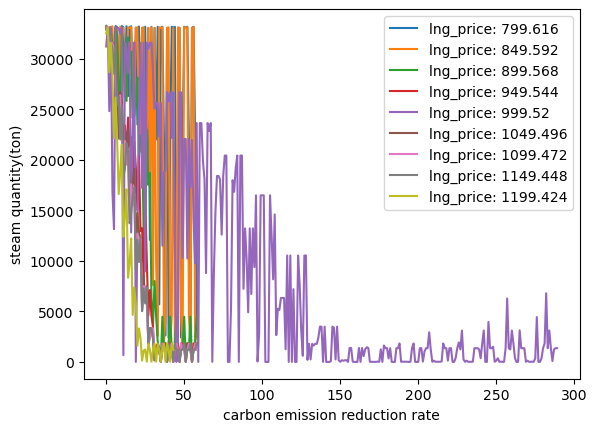

Steam quantaty for B


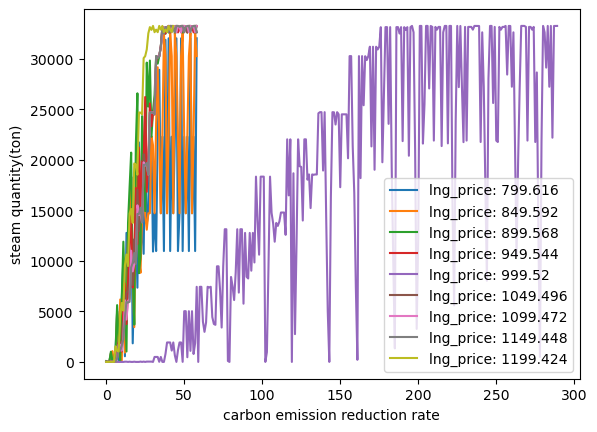

Steam quantaty for C


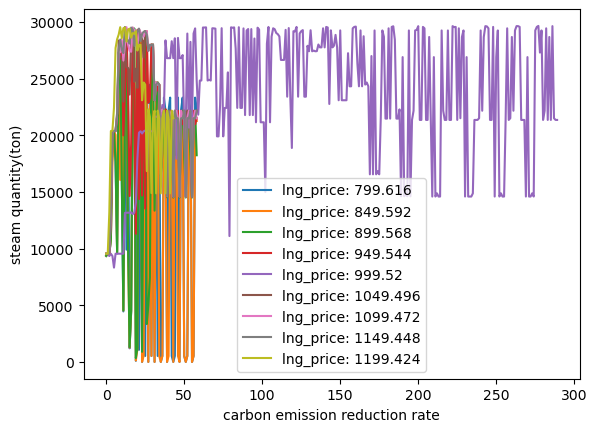

Steam quantaty for S50T


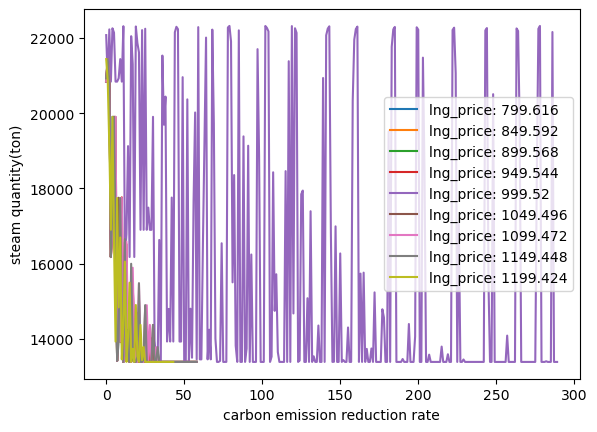

Steam quantaty for S20T


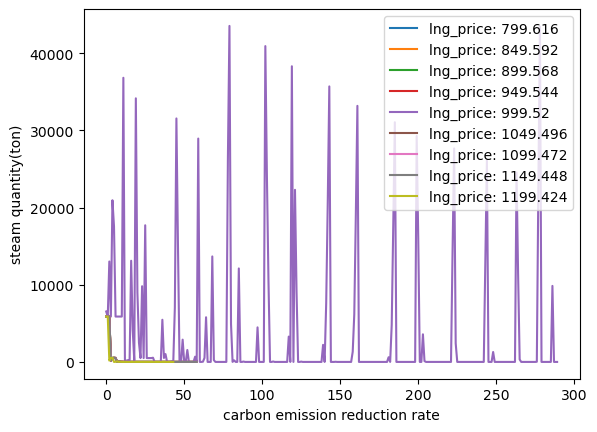

In [18]:
print('Steam quantaty for A')
lng_price_list
for key in lng_price_list:
    final_result = lng_co2_final_result[key]
    #plt.title(f'')
    plt.plot(final_result['A_qty'], label=f'lng_price: {key}')
    plt.xlabel('carbon emission reduction rate')
    plt.ylabel('steam quantity(ton)')
    plt.legend()#loc='lower right'
plt.show()

print('Steam quantaty for B')
for key in lng_price_list:
    final_result = lng_co2_final_result[key]
    plt.plot(final_result['B_qty'], label=f'lng_price: {key}')
    plt.xlabel('carbon emission reduction rate')
    plt.ylabel('steam quantity(ton)')
    plt.legend()#loc='lower right'
plt.show()

print('Steam quantaty for C')
for key in lng_price_list:
    final_result = lng_co2_final_result[key]
    #plt.title(f'')
    
    # plt.plot(final_result['A_qty'], label=f'lng_price: {key}')
    # plt.plot(final_result['B_qty'], label=f'lng_price: {key}')
    plt.plot(final_result['C_qty'], label=f'lng_price: {key}')
    # plt.plot(final_result['S50T_qty'], label=f'lng_price: {key}')
    # plt.plot(final_result['S20T_qty'], label=f'lng_price: {key}')
    #plt.text(1, max(-opt_qty_df['total_demand']+org_qty_df['total']), f'기존: {surplus_steam} 만 톤| 최적 운전: {0} 만 톤 | 총 절감 스팀: {surplus_steam} 만 톤')
    plt.xlabel('carbon emission reduction rate')
    plt.ylabel('steam quantity(ton)')
    plt.legend()#loc='lower right'
plt.show()


print('Steam quantaty for S50T')
for key in lng_price_list:
    final_result = lng_co2_final_result[key]
    plt.plot(final_result['S50T_qty'], label=f'lng_price: {key}')
    plt.xlabel('carbon emission reduction rate')
    plt.ylabel('steam quantity(ton)')
    plt.legend()#loc='lower right'
plt.show()

print('Steam quantaty for S20T')
for key in lng_price_list:
    final_result = lng_co2_final_result[key]
    plt.plot(final_result['S20T_qty'], label=f'lng_price: {key}')
    plt.xlabel('carbon emission reduction rate')
    plt.ylabel('steam quantity(ton)')
    plt.legend()#loc='lower right'
plt.show()



In [57]:
org_cost_total_df['total']

5944044999.295069

In [58]:
final_result

A_qty         B_qty         C_qty     S20T_qty      S50T_qty  \
0.28  32706.879068      5.491399   8411.434758  1281.255964  18756.147366   
0.27  31616.932571     19.903051  13172.856854   171.979873  16179.536205   
0.26  29159.200410     66.197723  17859.185735     1.590563  14075.034123   
0.25  25396.590631    347.487391  21997.239580     0.000000  13419.890952   
0.24  21711.062490   1159.791504  24896.669799     0.000000  13393.684761   
0.23  18306.233984   2201.144079  27261.830490     0.000000  13392.000000   
0.22  16009.916002   4075.559018  27683.733533     0.000000  13392.000000   
0.21  13719.913569   5954.663686  28094.631299     0.000000  13392.000000   
0.20  11389.685900   7803.133817  28576.388837     0.000000  13392.000000   
0.19   9148.701531   9717.546517  28902.960506     0.000000  13392.000000   
0.18   6985.154663  11688.273325  29095.780565     0.000000  13392.000000   
0.17   5023.033576  13808.500542  28937.674435     0.000000  13392.000000   
0.16   3242.169242  16060.161784  28466.877528     0.000000  13392.000000   
0.15   1766.694398  18537.997163  27464.516993     0.000000  13392.000000   
0.14    718.251043  21335.052308  25715.905202     0.000000  13392.000000   
0.13    168.178200  24505.460159  23095.570195     0.000000  13392.000000   
0.12     16.382815  27967.464369  19785.361370     0.000000  13392.000000   
0.11     13.349225  31198.105769  16557.753559     0.000000  13392.000000   
0.10     13.349225  32779.279441  14976.579887     0.000000  13392.000000   
0.09     13.349225  33137.501368  14618.357960     0.000000  13392.000000   
0.08     13.349225  33159.190664  14596.668664     0.000000  13392.000000   
0.07     13.349225  33159.190664  14596.668664     0.000000  13392.000000   
0.06     13.349225  33159.190664  14596.668664     0.000000  13392.000000   
0.05     13.349225  33159.190664  14596.668664     0.000000  13392.000000   
0.04     13.349225  33159.190664  14596.668664     0.000000  13392.000000   
0.03     13.349225  33159.190664  14596.668664     0.000000  13392.000000   
0.02     13.349225  33159.190664  14596.668664     0.000000  13392.000000   
0.01     13.349225  33159.190664  14596.668664     0.000000  13392.000000   
0.00     13.349225  33159.190664  14596.668664     0.000000  13392.000000   

      total_opt_cost      total_co2  
0.28       51.536680  134837.217517  
0.27       47.661682  136710.297583  
0.26       45.072161  138583.094786  
0.25       43.941040  140455.839310  
0.24       43.514445  142328.583834  
0.23       43.223763  144201.328358  
0.22       42.954086  146074.038193  
0.21       42.689025  147946.722169  
0.20       42.395841  149819.172879  
0.19       42.067894  151691.088116  
0.18       41.702753  153562.067596  
0.17       41.321580  155432.184819  
0.16       40.949673  157299.914173  
0.15       40.612174  159166.081544  
0.14       40.341027  161031.603731  
0.13       40.159226  162896.791841  
0.12       40.053940  164758.187923  
0.11       39.984621  166441.040515  
0.10       39.951004  167264.099524  
0.09       39.943388  167450.567203  
0.08       39.942927  167461.857279  
0.07       39.942927  167461.857279  
0.06       39.942927  167461.857279  
0.05       39.942927  167461.857279  
0.04       39.942927  167461.857279  
0.03       39.942927  167461.857279  
0.02       39.942927  167461.857279  
0.01       39.942927  167461.857279  
0.00       39.942927  167461.857279

799.616
cost
849.592
cost
899.568
cost
949.544
cost
999.52
cost
1049.496
cost
1099.472
cost
1149.448
cost


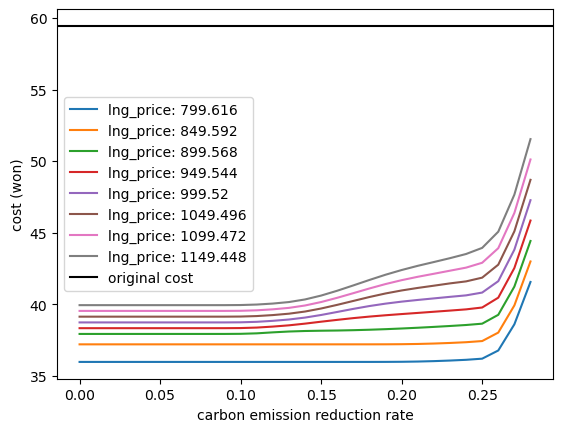

In [61]:
for key in lng_price_list:
    print(key)
    final_result = lng_co2_final_result[key]
    #plt.title(f'')
    # print('Steam quantaty')
    # plt.plot(final_result['A_qty'], label='A')
    # plt.plot(final_result['B_qty'], label='B')
    # plt.plot(final_result['C_qty'], label='C')
    # plt.plot(final_result['S50T_qty'], label='S50T')
    # plt.plot(final_result['S20T_qty'], label='S20T')
    # #plt.text(1, max(-opt_qty_df['total_demand']+org_qty_df['total']), f'기존: {surplus_steam} 만 톤| 최적 운전: {0} 만 톤 | 총 절감 스팀: {surplus_steam} 만 톤')
    # plt.xlabel('carbon emission reduction rate')
    # plt.ylabel('steam quantity(ton)')
    # plt.legend()#loc='lower right'
    # #plt.axhline(y=0, color='black')
    # plt.show()

    # #plt.title(f'')
    print('cost')
    plt.plot(final_result['total_opt_cost'], label=f'lng_price: {key}')
    plt.xlabel('carbon emission reduction rate')
    plt.ylabel('cost (won)')
    plt.legend()#loc='lower right'
    # plt.show()

    # # #plt.title(f'')
    # print('cost_saving')
    # plt.plot(final_result['total_opt_cost']/final_result['total_opt_cost'][0]-1, label='total cost')
    # #plt.plot(final_result.index, label='standard')
    # plt.xlabel('carbon emission reduction rate')
    # plt.ylabel('increasing cost (won)')
    # plt.legend()#loc='lower right'
    # #plt.axhline(y=0, color='black')


    # print('cost_saving')
    # plt.plot(1-final_result['total_co2']/final_result['total_co2'][0], label='total cost')
    # #plt.plot(final_result.index, label='standard')
    # plt.xlabel('carbon emission reduction rate')
    # plt.ylabel('increasing cost (won)')
    # plt.legend()#loc='lower right'
    # #plt.axhline(y=0, color='black')
    # #plt.show()
plt.axhline(y=round(org_cost_total_df['total']/100000000, 10), color='black', label='original cost')
plt.legend()#loc='lower right'



In [51]:
# 탄소 배출권 가격에 따른 비용 비교
def A_price_func(x, lng_price):
    if x <10:
        A_price = 57*lng_price
    elif (10<=x) & (x<20):
        A_price = 55*lng_price
    elif (20<=x) & (x<30):
        A_price = 53*lng_price
    elif 30<=x:
        A_price = 50*lng_price
    return A_price
co2_reduction_rate_list = [ 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
lng_co2_file_nm_df = result_file_nm_df[(result_file_nm_df['co2_price']==35000)].sort_values('co2_reduction')

lng_co2_final_result = dict()
lng_price_list = sorted(list(lng_co2_file_nm_df['lng_price'].unique()))
lng_price = 999.52

file_nm_df = lng_co2_file_nm_df[lng_co2_file_nm_df['lng_price']==lng_price]
for co2_price in [30000, 31000,32000, 33000, 34000, 35000, 36000, 37000]: # 
    

    result_plot_list = []
    for idx, file_nm in file_nm_df.iterrows():
        path = file_nm['path']
        print(path)
        lng_price = file_nm['lng_price']
        result_df = pd.read_csv(path)
        price = PRICE(bc_price, lng_price, co2_price)

        qty_df = pd.DataFrame()
        A_qty = result_df['A'].apply(lambda x: x*5/60)
        B_qty = result_df['B'].apply(lambda x: x*5/60)
        C_qty = result_df['C'].apply(lambda x: x*5/60)
        S20T_qty = result_df['S20T'].apply(lambda x: x*5/60)
        S50T_qty = result_df['S50T'].apply(lambda x: x*5/60)
        qty_df['A_qty'] = A_qty
        qty_df['B_qty'] = B_qty
        qty_df['C_qty'] = C_qty
        qty_df['S50T_qty'] = S50T_qty
        qty_df['S20T_qty'] = S20T_qty
        qty_df['total'] = qty_df.apply(lambda x: x.sum(), axis=1)
        opt_qty_total_df = qty_df.apply(lambda x: x.sum(), axis=0)

        A_opt_qty = opt_qty_total_df['A_qty']
        B_opt_qty = opt_qty_total_df['B_qty']
        C_opt_qty = opt_qty_total_df['C_qty']
        S20T_opt_qty = opt_qty_total_df['S20T_qty']
        S50T_opt_qty = opt_qty_total_df['S50T_qty']


        cost_df = pd.DataFrame()
        A_cost = result_df['A'].apply(lambda x: x*A_price_func(x, lng_price)*5/60)
        B_cost = result_df['B'].apply(lambda x: x*price.B_price()*5/60)
        C_cost = result_df['C'].apply(lambda x: x*price.C_price()*5/60)
        S20T_cost = result_df['S20T'].apply(lambda x: x*price.S20T_price()*5/60)
        S50T_cost = result_df['S50T'].apply(lambda x: x*price.S50T_price()*5/60)
        cost_df['A_cost'] = A_cost
        cost_df['B_cost'] = B_cost
        cost_df['C_cost'] = C_cost
        cost_df['S50T_cost'] = S50T_cost
        cost_df['S20T_cost'] = S20T_cost
        cost_df['co2_price'] = (result_df['S20T']+result_df['S50T'])*5/60*price.co2_em(type='LNG')*price.co2_price
        cost_df['total'] = cost_df.apply(lambda x: x.sum(), axis=1)
        opt_cost_total_df = cost_df.apply(lambda x: x.sum(), axis=0)

        A_co2 = result_df['A'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
        B_co2 = result_df['B'].apply(lambda x: x*price.co2_em(type='bc')*5/60)
        C_co2 = result_df['C'].apply(lambda x: x*price.co2_em(type='waste')*5/60)
        S20T_co2 = result_df['S20T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
        S50T_co2 = result_df['S50T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
        co2_df = pd.DataFrame()
        co2_df['A_co2'] = A_co2
        co2_df['B_co2'] = B_co2
        co2_df['C_co2'] = C_co2
        co2_df['S50T_co2'] = S50T_co2
        co2_df['S20T_co2'] = S20T_co2
        co2_df['total'] = co2_df.apply(lambda x: x.sum(), axis=1)
        opt_co2_total_df = co2_df.apply(lambda x: x.sum(), axis=0)

        total_opt_cost = round(opt_cost_total_df['total']/100000000, 10)
        total_opt_qty = round(opt_qty_total_df['total']/10000, 10)

        result_plot_list.append([A_opt_qty, B_opt_qty, C_opt_qty, S20T_opt_qty, S50T_opt_qty, total_opt_cost, opt_co2_total_df['total']])
    final_result = pd.DataFrame(result_plot_list, columns=['A_qty', 'B_qty', 'C_qty', 'S20T_qty', 'S50T_qty', 'total_opt_cost', 'total_co2'])
    final_result.index = [round(1-x, 2) for x in co2_reduction_rate_list]
    lng_co2_final_result[co2_price] = final_result



opt_qty_1_72_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_73_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_74_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_75_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_76_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_77_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_78_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_79_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_80_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_81_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_82_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_83_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price30000
opt_qty_1_84_999.52_35000.csv
bc_price:924.38,lng_pr

ValueError: Length mismatch: Expected axis has 29 elements, new values have 16 elements

30000
cost
31000
cost
32000
cost
33000
cost
34000
cost
35000
cost
36000
cost
37000
cost


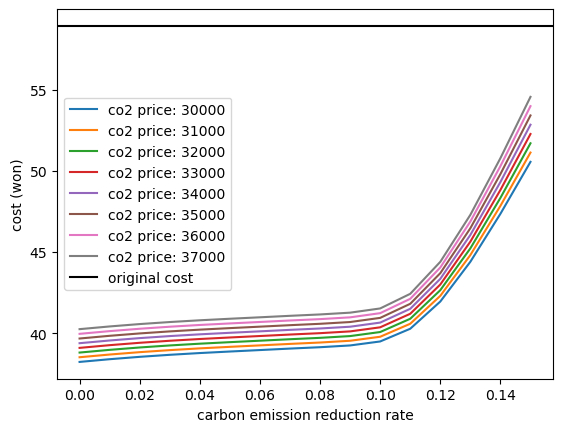

In [ ]:

for key in [30000, 31000,32000, 33000, 34000, 35000, 36000, 37000]:
    print(key)
    final_result = lng_co2_final_result[key]

    print('cost')
    plt.plot(final_result['total_opt_cost'], label=f'co2 price: {key}')
    plt.xlabel('carbon emission reduction rate')
    plt.ylabel('cost (won)')
    plt.legend()#loc='lower right'

plt.axhline(y=round(org_cost_total_df['total']/100000000, 10), color='black', label='original cost')
plt.legend()#loc='lower right'



In [12]:
path_list = [] 
for path in os.listdir('.'):
    if 'opt_TVP_' in path:
        org_path = path
        path = path.replace('.csv', '')
        path = path.replace('opt_TVP_', '')
        path = path.split('_')
        path = [float(x) for x in path]
        path.append(org_path)
        path_list.append(path)
result_file_nm_df = pd.DataFrame(path_list, columns=['month', 'co2_reduction', 'lng_price', 'co2_price','path',])
result_file_nm_df


def A_price_func(x, lng_price):
    if x <10:
        A_price = 57*lng_price
    elif (10<=x) & (x<20):
        A_price = 55*lng_price
    elif (20<=x) & (x<30):
        A_price = 53*lng_price
    elif 30<=x:
        A_price = 50*lng_price
    return A_price
co2_reduction_rate_list = [1]
lng_co2_file_nm_df = result_file_nm_df[(result_file_nm_df['co2_price']==35000)].sort_values('co2_reduction')
co2_price = 35000
bc_price = 924.38
lng_price=999.52
lng_co2_final_result = dict()
lng_price_list = sorted(list(lng_co2_file_nm_df['lng_price'].unique()))
for lng_price in lng_price_list:
    file_nm_df = lng_co2_file_nm_df[lng_co2_file_nm_df['lng_price']==lng_price]
    result_plot_list = []
    for idx, file_nm in file_nm_df.iterrows():
        #print(file_nm)
        path = file_nm['path']
        print(path)
        lng_price = file_nm['lng_price']
        price = PRICE(bc_price, lng_price, co2_price)
        result_df = pd.read_csv(path)

        qty_df = pd.DataFrame()
        A_qty = result_df['A'].apply(lambda x: x*5/60)
        B_qty = result_df['B'].apply(lambda x: x*5/60)
        C_qty = result_df['C'].apply(lambda x: x*5/60)
        S20T_qty = result_df['S20T'].apply(lambda x: x*5/60)
        S50T_qty = result_df['S50T'].apply(lambda x: x*5/60)
        qty_df['A_qty'] = A_qty
        qty_df['B_qty'] = B_qty
        qty_df['C_qty'] = C_qty
        qty_df['S50T_qty'] = S50T_qty
        qty_df['S20T_qty'] = S20T_qty
        qty_df['total'] = qty_df.apply(lambda x: x.sum(), axis=1)
        opt_qty_total_df = qty_df.apply(lambda x: x.sum(), axis=0)

        A_opt_qty = opt_qty_total_df['A_qty']
        B_opt_qty = opt_qty_total_df['B_qty']
        C_opt_qty = opt_qty_total_df['C_qty']
        S20T_opt_qty = opt_qty_total_df['S20T_qty']
        S50T_opt_qty = opt_qty_total_df['S50T_qty']


        cost_df = pd.DataFrame()
        A_cost = result_df['A'].apply(lambda x: x*A_price_func(x, lng_price)*5/60)
        B_cost = result_df['B'].apply(lambda x: x*price.B_price()*5/60)
        C_cost = result_df['C'].apply(lambda x: x*price.C_price()*5/60)
        S20T_cost = result_df['S20T'].apply(lambda x: x*price.S20T_price()*5/60)
        S50T_cost = result_df['S50T'].apply(lambda x: x*price.S50T_price()*5/60)
        cost_df['A_cost'] = A_cost
        cost_df['B_cost'] = B_cost
        cost_df['C_cost'] = C_cost
        cost_df['S50T_cost'] = S50T_cost
        cost_df['S20T_cost'] = S20T_cost
        cost_df['co2_price'] = (result_df['S20T']+result_df['S50T'])*5/60*price.co2_em(type='LNG')*price.co2_price
        cost_df['total'] = cost_df.apply(lambda x: x.sum(), axis=1)
        opt_cost_total_df = cost_df.apply(lambda x: x.sum(), axis=0)

        A_co2 = result_df['A'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
        B_co2 = result_df['B'].apply(lambda x: x*price.co2_em(type='bc')*5/60)
        C_co2 = result_df['C'].apply(lambda x: x*price.co2_em(type='waste')*5/60)
        S20T_co2 = result_df['S20T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
        S50T_co2 = result_df['S50T'].apply(lambda x: x*price.co2_em(type='LNG')*5/60)
        co2_df = pd.DataFrame()
        co2_df['A_co2'] = A_co2
        co2_df['B_co2'] = B_co2
        co2_df['C_co2'] = C_co2
        co2_df['S50T_co2'] = S50T_co2
        co2_df['S20T_co2'] = S20T_co2
        co2_df['total'] = co2_df.apply(lambda x: x.sum(), axis=1)
        opt_co2_total_df = co2_df.apply(lambda x: x.sum(), axis=0)

        total_opt_cost = round(opt_cost_total_df['total']/100000000, 10)
        total_opt_qty = round(opt_qty_total_df['total']/10000, 10)

        result_plot_list.append([A_opt_qty, B_opt_qty, C_opt_qty, S20T_opt_qty, S50T_opt_qty, total_opt_cost, opt_co2_total_df['total']])
    final_result = pd.DataFrame(result_plot_list, columns=['A_qty', 'B_qty', 'C_qty', 'S20T_qty', 'S50T_qty', 'total_opt_cost', 'total_co2'])
    final_result.index = [round(1-x, 2) for x in co2_reduction_rate_list]
    lng_co2_final_result[lng_price] = final_result


lng_co2_final_result

opt_TVP_1_100_999.52_35000.csv
bc_price:924.38,lng_price:999.52, co2_price35000


{999.52:           A_qty        B_qty         C_qty    S20T_qty      S50T_qty  \
 0  22110.101181  31202.54324  29733.120941  372.177703  15942.262209   
 
    total_opt_cost      total_co2  
 0       59.737638  253750.749778  }

# 논문을 위한 작업

In [15]:
df_2021 = pd.read_csv(os.path.join('data','data_2021.csv'))
df_2020 = pd.read_csv(os.path.join('data','data_2020.csv'))

column_dict = {
    'A사 유량\n(t/h)': 'A사 유량',
    'A사 압력\n(kg/cm2)': 'A사 압력',
    'B사 유량\n(t/h)': 'B사 유량',
    'B사 압력\n(kg/cm2)': 'B사 압력',
    'C사 유량\n(t/h)': 'C사 유량',
    'C사 압력\n(kg/cm2)': 'C사 압력',
    'C사 온도\n(℃)': 'C사 온도',
    '50톤 보일러 유량\n(t/h)': '50톤 보일러 유량',
    '50톤 보일러 압력\n(kg/cm2)': '50톤 보일러 압력',
    '20톤 보일러 유량\n(t/h)': '20톤 보일러 유량',
    '20톤 보일러 압력\n(kg/cm2)': '20톤 보일러 압력',
    '50톤 보일러 NOx 농도\n(ppm)': '50톤 보일러 NOx 농도',
    '20톤 보일러 NOx 농도\n(ppm)': '20톤 보일러 NOx 농도',
    'CO2 유량\n(m3/h)': 'CO2 유량',
    'CO2 농도\n(%)': 'CO2 농도',
    'D사 유량\n(t/h)': 'D사 유량',
    '울산1공장 유량(6K)\n(t/h)': '울산1공장 유량(6K)',
    '울산1공장 유량(1.5K)\n(t/h)': '울산1공장 유량(1.5K)',
    '울산2공장 유량(400A)\n(t/h)': '울산2공장 유량(400A)',
    '울산2공장 유량(250A)\n(t/h)': '울산2공장 유량(250A)',
    '수지공장 유량\n(t/h)': '수지공장 유량',
    '공급 Total\n(t/h)': '공급 Total',
    '수요 Total\n(t/h)':  '수요 Total',
}

df_2021 = df_2021.rename(columns=column_dict)    
df_2020 = df_2020.rename(columns=column_dict)    
df_2020


date      A사 유량      A사 압력      B사 유량      B사 압력  \
0        2020-01-01 0:00   5.173781  26.957933  24.921297  11.827349   
1        2020-01-01 0:05   5.078577  26.569721  23.904821  11.829329   
2        2020-01-01 0:10   5.017150  26.166628  25.072395  11.931910   
3        2020-01-01 0:15   5.030494  25.883917  26.251537  12.043219   
4        2020-01-01 0:20   4.989506  25.581848  25.130508  12.006857   
...                  ...        ...        ...        ...        ...   
105260  2020-12-31 11:40  15.083446  23.384481  16.889133   9.663545   
105261  2020-12-31 11:45  15.931343  23.303095  11.271457   9.113613   
105262  2020-12-31 11:50  15.525436  23.323814  11.430475   9.816314   
105263  2020-12-31 11:55  14.869235  23.370356  18.430235   9.990239   
105264  2020-12-31 12:00  15.593712  23.216526  17.219154   9.315346   

            C사 유량      C사 압력       C사 온도  50톤 보일러 유량  50톤 보일러 압력  ...  \
0       37.444504  35.513088  282.730988   21.866743    9.561617  ...   
1       36.056232  34.718308  282.784210   20.751276    9.831614  ...   
2       27.251209  37.543365  281.499481   22.161919    9.657163  ...   
3       36.544495  36.692276  280.203308   20.880993    9.473224  ...   
4       33.815388  36.245525  281.458649   22.322762    9.728888  ...   
...           ...        ...         ...         ...         ...  ...   
105260  31.954048  27.042587  248.054443   23.079983    9.552005  ...   
105261  36.668159  25.779190  246.929810   24.636641    9.213989  ...   
105262  36.085033  25.682507  251.198731   22.526377    9.913590  ...   
105263  25.809446  29.147978  253.176666   24.876141    9.831989  ...   
105264  34.683887  29.490261  251.197113   23.875431    9.214970  ...   

            CO2 유량    CO2 농도     D사 유량 울산1공장 유량(6K)  울산1공장 유량(1.5K)  \
0       124.589996  8.915408 -0.006373     8.000673       28.426874   
1       124.534981  8.892123 -0.007285     2.583441       29.271191   
2       124.448364  8.893757 -0.006464     2.637950       28.720798   
3       123.245308  8.871835 -0.004909     7.928742       34.981930   
4       122.218811  8.891842 -0.006255     2.398186       36.420338   
...            ...       ...       ...          ...             ...   
105260  116.720177  9.834411 -0.003807     7.705378       20.140802   
105261  115.580887  9.740149 -0.003780     6.337985       19.082317   
105262  115.828537  9.795649 -0.006057     4.479355       17.721144   
105263  115.829582  9.834661 -0.003144     7.195423       21.685839   
105264  117.061584  9.886547 -0.003003     6.482623       23.158705   

        울산2공장 유량(400A)  울산2공장 유량(250A)   수지공장 유량   공급 Total   수요 Total  
0            34.315712      <No Value>  2.913484  89.321602  80.506859  
1            35.442963      <No Value>  2.644756  85.676048  73.891327  
2            32.748650      <No Value>  2.575827  79.422096  70.579384  
3            29.913898      <No Value>  2.852172  88.615494  81.812996  
4            30.067167      <No Value>  2.782337  86.160347  76.239388  
...                ...             ...       ...        ...        ...  
105260       38.748795      <No Value>  2.423500  87.038200  76.843590  
105261       39.001217      <No Value>  3.100050  88.544640  77.753601  
105262       40.812031      <No Value>  2.207791  85.627220  71.498741  
105263       38.393051      <No Value>  3.280087  84.026985  76.923866  
105264       39.191612      <No Value>  2.443400  91.405449  80.423058  

[105265 rows x 24 columns]

In [16]:
df_total = pd.concat([df_2020, df_2021, df])
df_total = df_total.replace('<No Value>', 0)
df_total = df_total.fillna(0)
df_total['year'] = df_total['date'].apply(lambda x: x.split('-')[0].zfill(2))
df_total['month'] = df_total['date'].apply(lambda x: x.split('-')[1].zfill(2))
df_total['day'] = df_total['date'].apply(lambda x: x.split('-')[2][:2])
df_total['time'] = df_total['date'].apply(lambda x: x.split('-')[2][2:].split(':')[0])
df_total['time2'] = df_total['date'].apply(lambda x: x.split('-')[2][2:].split(':')[1])

df_total['A_stop']=df_total['A사 유량'].apply(lambda x: 1 if x < 5 else 0)
df_total['B_stop']=df_total['B사 유량'].apply(lambda x: 1 if x < 5 else 0)
df_total['C_stop']=df_total['C사 유량'].apply(lambda x: 1 if x < 5 else 0)


A_stop_df = df_total[['year','month', 'A_stop']].groupby(['year', 'month']).mean().reset_index()
A_stop_df


year month    A_stop
0   2020    01  0.191868
1   2020    02  0.049090
2   2020    03  0.051523
3   2020    04  0.237037
4   2020    05  0.814852
5   2020    06  0.379745
6   2020    07  0.176523
7   2020    08  0.336918
8   2020    09  0.180208
9   2020    10  0.111447
10  2020    11  0.002662
11  2020    12  0.002049
12  2021    01  0.015233
13  2021    02  0.209697
14  2021    03  0.076613
15  2021    04  0.009144
16  2021    05  0.002240
17  2021    06  0.013889
18  2021    07  0.006048
19  2021    08  0.124328
20  2021    09  0.196181
21  2021    10  0.886313
22  2021    11  1.000000
23  2021    12  0.862607
24  2022    01  0.114583
25  2022    02  0.031746
26  2022    03  0.098454
27  2022    04  0.082060
28  2022    05  0.542787
29  2022    06  0.143287
30  2022    07  0.041443
31  2022    08  0.000000

In [17]:
B_stop_df = df_total[['year','month', 'B_stop']].groupby(['year', 'month']).mean().reset_index()
B_stop_df



year month    B_stop
0   2020    01  0.000000
1   2020    02  0.000000
2   2020    03  0.000000
3   2020    04  0.000116
4   2020    05  0.000000
5   2020    06  0.004282
6   2020    07  0.000000
7   2020    08  0.000000
8   2020    09  0.015625
9   2020    10  0.000112
10  2020    11  0.003819
11  2020    12  0.000000
12  2021    01  0.000784
13  2021    02  0.186384
14  2021    03  0.076613
15  2021    04  0.000000
16  2021    05  0.000000
17  2021    06  0.000000
18  2021    07  0.000000
19  2021    08  0.000000
20  2021    09  0.000000
21  2021    10  0.000112
22  2021    11  0.101620
23  2021    12  0.185316
24  2022    01  0.000000
25  2022    02  0.000000
26  2022    03  0.011089
27  2022    04  0.001273
28  2022    05  0.000000
29  2022    06  0.000000
30  2022    07  0.000000
31  2022    08  0.000000

In [18]:
C_stop_df = df_total[['year','month', 'C_stop']].groupby(['year', 'month']).mean().reset_index()
C_stop_df


year month    C_stop
0   2020    01  0.055444
1   2020    02  0.000000
2   2020    03  0.000112
3   2020    04  0.000000
4   2020    05  0.000000
5   2020    06  0.015394
6   2020    07  0.009633
7   2020    08  0.000560
8   2020    09  0.058565
9   2020    10  0.000336
10  2020    11  0.018866
11  2020    12  0.000000
12  2021    01  0.037074
13  2021    02  0.186632
14  2021    03  0.099350
15  2021    04  0.035185
16  2021    05  0.029458
17  2021    06  0.000000
18  2021    07  0.140569
19  2021    08  0.028674
20  2021    09  0.000116
21  2021    10  0.038978
22  2021    11  0.161343
23  2021    12  0.185316
24  2022    01  0.058244
25  2022    02  0.000000
26  2022    03  0.016577
27  2022    04  0.000694
28  2022    05  0.002240
29  2022    06  0.003241
30  2022    07  0.048835
31  2022    08  0.000000

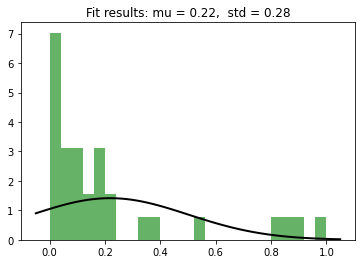

In [19]:
from scipy.stats import norm, skewnorm, probplot, shapiro, anderson
data = A_stop_df['A_stop']
mu, std = norm.fit(data)

plt.hist(data, bins=25, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [20]:
shapiro(data)

ShapiroResult(statistic=0.7256029844284058, pvalue=2.1487123831320787e-06)

In [21]:
y,x=np.histogram(data,bins=25)
y

array([9, 4, 4, 2, 4, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1])

In [22]:
x

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92, 0.96, 1.  ])

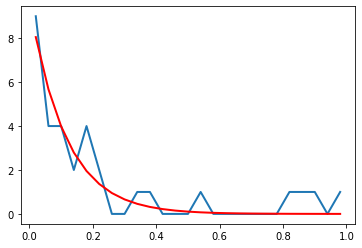

In [23]:
from scipy.optimize import curve_fit
from scipy.special import factorial

def poisson(k, lamb, scale):
    return scale*(lamb**k/factorial(k))*np.exp(-lamb)


y,x=np.histogram(data,bins=25)
x = x + (x[1]-x[0])/2
x = np.delete(x,-1)
parameters, cov_matrix = curve_fit(poisson, x, y, p0=[10., 10.])
parameters
plt.plot(x, y, linewidth=2)
plt.plot(x, poisson(x, *parameters), color='red', linewidth=2)


In [24]:
#!pip install fitter

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 14.00it/s]


sumsquare_error         aic        bic  kl_div  ks_statistic  \
lognorm       252.993074  218.278749  76.561246     inf      0.135439   
burr          256.458400  271.893546  80.462322     inf      0.216758   
beta          263.161305  100.215684  81.287944     inf      0.210870   
gamma         266.312391  188.989370  78.203099     inf      0.099261   
norm          554.760077  138.856208  98.221066     inf      0.262375   

         ks_pvalue  
lognorm   0.554503  
burr      0.084518  
beta      0.099921  
gamma     0.880173  
norm      0.019665

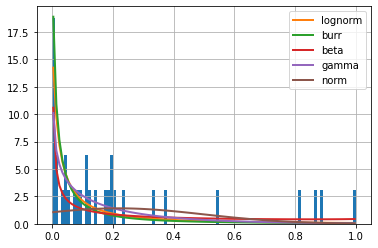

In [25]:
#https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9
from fitter import Fitter, get_common_distributions, get_distributions
f = Fitter(A_stop_df['A_stop'],
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [26]:
f.get_best(method = 'sumsquare_error')



{'lognorm': {'s': 1.8257132886417926,
  'loc': -0.0008381253075649779,
  'scale': 0.07383747860377055}}

In [27]:
f.fitted_param["lognorm"]


(1.8257132886417926, -0.0008381253075649779, 0.07383747860377055)

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 29.38it/s]


sumsquare_error         aic        bic  kl_div  ks_statistic  \
lognorm        252.993074  218.278749  76.561246     inf      0.135439   
exponpow       259.899764  154.373183  77.423132     inf      0.103120   
powerlaw       264.184140   87.925853  77.946342     inf      0.205664   
gamma          266.312391  188.989370  78.203099     inf      0.099261   
chi2           350.867789  156.829654  87.026762     inf      0.161813   

          ks_pvalue  
lognorm    0.554503  
exponpow   0.851235  
powerlaw   0.115407  
gamma      0.880173  
chi2       0.335111

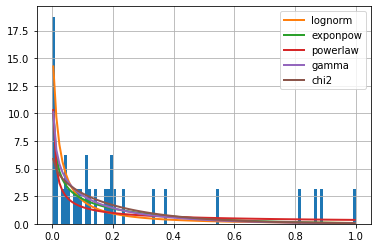

In [28]:
f = Fitter(data,
           distributions= get_common_distributions())
f.fit()
f.summary()

In [29]:
# Anderson-Darling Test --> normal 분포를 따르지 않음
anderson_result = anderson(data, dist='gumbel')

print(f'검정 통계치 : {anderson_result[0]}')
print(f'임계지점의 통계치 : {anderson_result[1]}')
print(f'각 임계 지점의 P-value : {anderson_result[2]}')

if anderson_result[0] < anderson_result[1][2]:
    print(f'해당 데이터의 검정 통계치 {round(anderson_result[0],3)}는 5% 유의수준 검정 통계치 {anderson_result[1][2]}보다 작다.\n따라서 정규분포를 따른다는 귀무가설을 기각할 수 없다.')
else:
    print(f'해당 데이터의 검정 통계치 {round(anderson_result[0],3)}는 5% 유의수준 검정 통계치 {anderson_result[1][2]}보다 크다.\n따라서 정규분포를 따른다는 귀무가설을 5%의 유의수준으로 기각할 수 있다.')

검정 통계치 : 4.265811415015932
임계지점의 통계치 : [0.458 0.615 0.731 0.847 1.003]
각 임계 지점의 P-value : [25.  10.   5.   2.5  1. ]
해당 데이터의 검정 통계치 4.266는 5% 유의수준 검정 통계치 0.731보다 크다.
따라서 정규분포를 따른다는 귀무가설을 5%의 유의수준으로 기각할 수 있다.


In [25]:
# Anderson-Darling Test --> normal 분포를 따르지 않음
anderson_result = anderson(data, dist= poisson(x, *parameters))

print(f'검정 통계치 : {anderson_result[0]}')
print(f'임계지점의 통계치 : {anderson_result[1]}')
print(f'각 임계 지점의 P-value : {anderson_result[2]}')

if anderson_result[0] < anderson_result[1][2]:
    print(f'해당 데이터의 검정 통계치 {round(anderson_result[0],3)}는 5% 유의수준 검정 통계치 {anderson_result[1][2]}보다 작다.\n따라서 정규분포를 따른다는 귀무가설을 기각할 수 없다.')
else:
    print(f'해당 데이터의 검정 통계치 {round(anderson_result[0],3)}는 5% 유의수준 검정 통계치 {anderson_result[1][2]}보다 크다.\n따라서 정규분포를 따른다는 귀무가설을 5%의 유의수준으로 기각할 수 있다.')

ValueError: Invalid distribution; dist must be 'norm', 'expon', 'gumbel', 'extreme1' or 'logistic'.